# Kr Fits

J. A Hernando, C. Herves

April 2022

In [133]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [134]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [135]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit

#import invisible_cities.io.dst_io as dio

In [136]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May  4 09:22:46 2022


In [137]:
#import os
import re
import glob

from collections import namedtuple

## Code

In [138]:
size             = 100
e0, tau0, length = 41.5, 10, 1.
wi               = 41.5/2000.

def generate_toy(size, e0 = e0, tau0 = tau0, length = length, sigma_ref = 0.04):
    
    ts = length * stats.uniform.rvs(size = size)
    es  = e0 * ((1 - ts/tau0) + sigma_ref * stats.norm.rvs(size = size))
    return ts, es

@np.vectorize
def attachment(t, lifetime, n_ie):
    return np.count_nonzero(-lifetime * np.log(np.random.uniform(size=int(n_ie))) > t)

def generate_toy_att(size = size, e0 = e0, tau0 = tau0, length = length, wi = wi):
    nie0     = e0/wi
    tis      = length * stats.uniform.rvs(size = size)
    nies     = stats.poisson.rvs(nie0, size = size)
    nis      = attachment(tis, tau0, nies)
    eis      = e0 * nis/nie0
    return tis, eis

def generate_toy_bin(size = size, e0 = e0, tau0 = tau0, length = length, wi = wi):
    nie0     = e0/wi
    tis      = length * stats.uniform.rvs(size = size)
    nies     = stats.poisson.rvs(nie0, size = size)
    ps       = 1 - tis/tau0
    nks      = stats.binom.rvs(nies, ps) * wi 
    return tis, nks

In [139]:
st_ipar = lambda t, a, b : a - b * t
st_cpar = lambda t, a, b : a * (1 - t / b) 

def chisq(fun, ts, es, pars): 
    res = (es - fun(ts, *pars)) 
    sig = np.sum(res * res)
    return sig

def experiments(generate, fun, e0 = e0, tau0 = tau0, mexps = 1000, size = 100):
    rs    = []
    for i in range(mexps):
        ts, es = generate(size = size, e0 = e0, tau0 = tau0)
        r      = optimize.curve_fit(fun, ts, es)
        #chi2   = chisq(fun, ts, es, r[0])
        rs.append((r[0], r[1])) 
    return rs

def plot_res(res, a0, b0, alabel = '', blabel = ''):
    
    alphas  = np.array([r[0][0] for r in res])
    betas   = np.array([r[0][1] for r in res])
    ualphas = np.array([np.sqrt(np.diag(r[1]))[0] for r in res])
    ubetas  = np.array([np.sqrt(np.diag(r[1]))[1] for r in res])
    cov     = np.array([r[1][0, 1]                for r in res])
    #chi2    = np.array([r[2] for r in res])

    canvas = pltext.canvas(8, 3)
    canvas(1)
    pltext.hist(alphas, 100);
    plt.xlabel(alabel);
    canvas(2)
    pltext.hist(ualphas, 100);
    plt.xlabel(alabel + ' uncertainty');
    canvas(3)
    pltext.hist((alphas - a0)/ualphas, 100);
    plt.xlabel(alabel + ' pool');

    canvas(4)
    pltext.hist(betas, 100);
    plt.xlabel(blabel);
    canvas(5)
    pltext.hist(ubetas, 100);
    plt.xlabel(blabel + ' uncertainty');
    canvas(6)
    pltext.hist((betas - b0)/ubetas, 100);
    plt.xlabel(blabel + ' pool');

    canvas(7)
    plt.hist2d(alphas, betas, (20, 20));
    plt.xlabel(alabel); plt.ylabel(blabel); plt.colorbar();
    canvas(8)
    pltext.hist(cov, 100);
    plt.xlabel('cov')
    
    plt.tight_layout()
    return

## Simple Generator

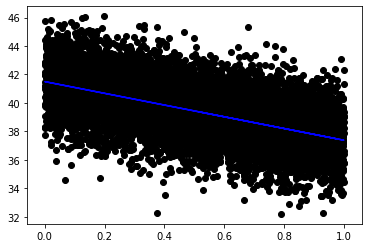

In [140]:
ts, es   = generate_toy(size = 100 * size)
par, cov = optimize.curve_fit(st_ipar, ts, es)
plt.scatter(ts, es);
plt.plot(ts, st_ipar(ts, *par), c = 'blue');

In [141]:
def residuals_(ts, es, par, cov):
    
    xv    = np.ones(shape = (2, len(ts)))
    xv[1] = -ts
    res   = np.dot(par, xv) - es

    var   = np.sum(xv * np.matmul(cov, xv), axis = 0)
    sig   = np.sqrt(var)
    
    sigma = np.sqrt(np.sum(res * res)/ (len(ts) - 2))
    return res, sig, sigma 

In [142]:
res, sig, sigma = residuals_(ts, es, par, cov)

In [143]:
chi2  = np.sum(res*res)
sigma = np.sqrt(np.sum(res*res)/(len(res)-2))
print(sigma)

1.653543619512703


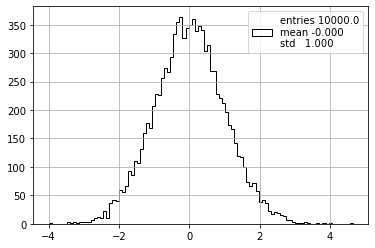

In [144]:
pltext.hist(res/sigma, 100);

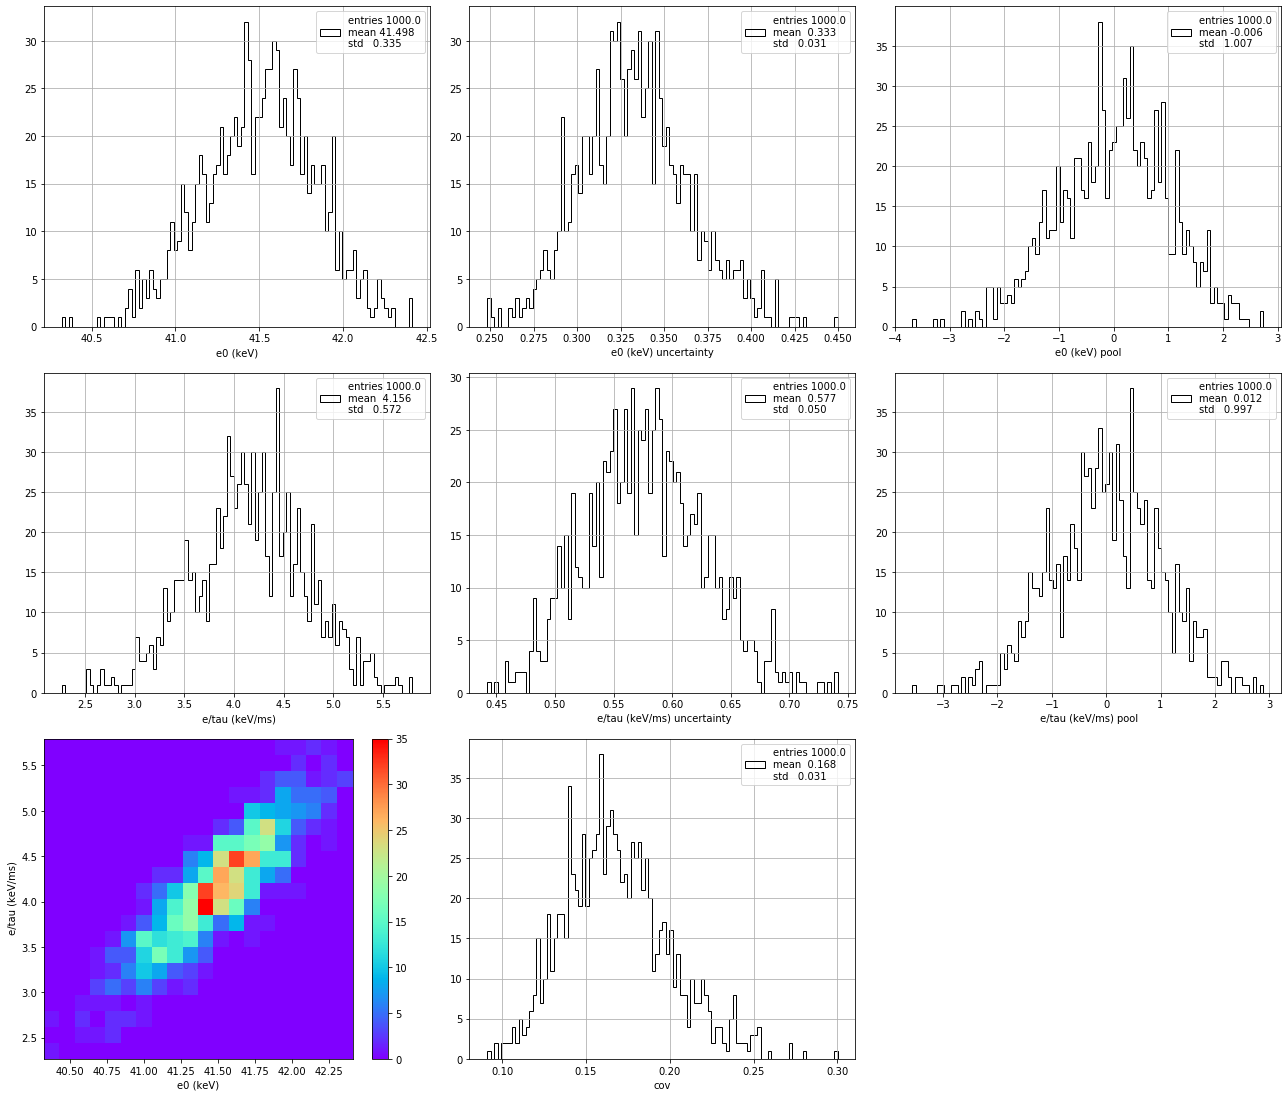

In [145]:
rs = experiments(generate_toy, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e/tau (keV/ms)')

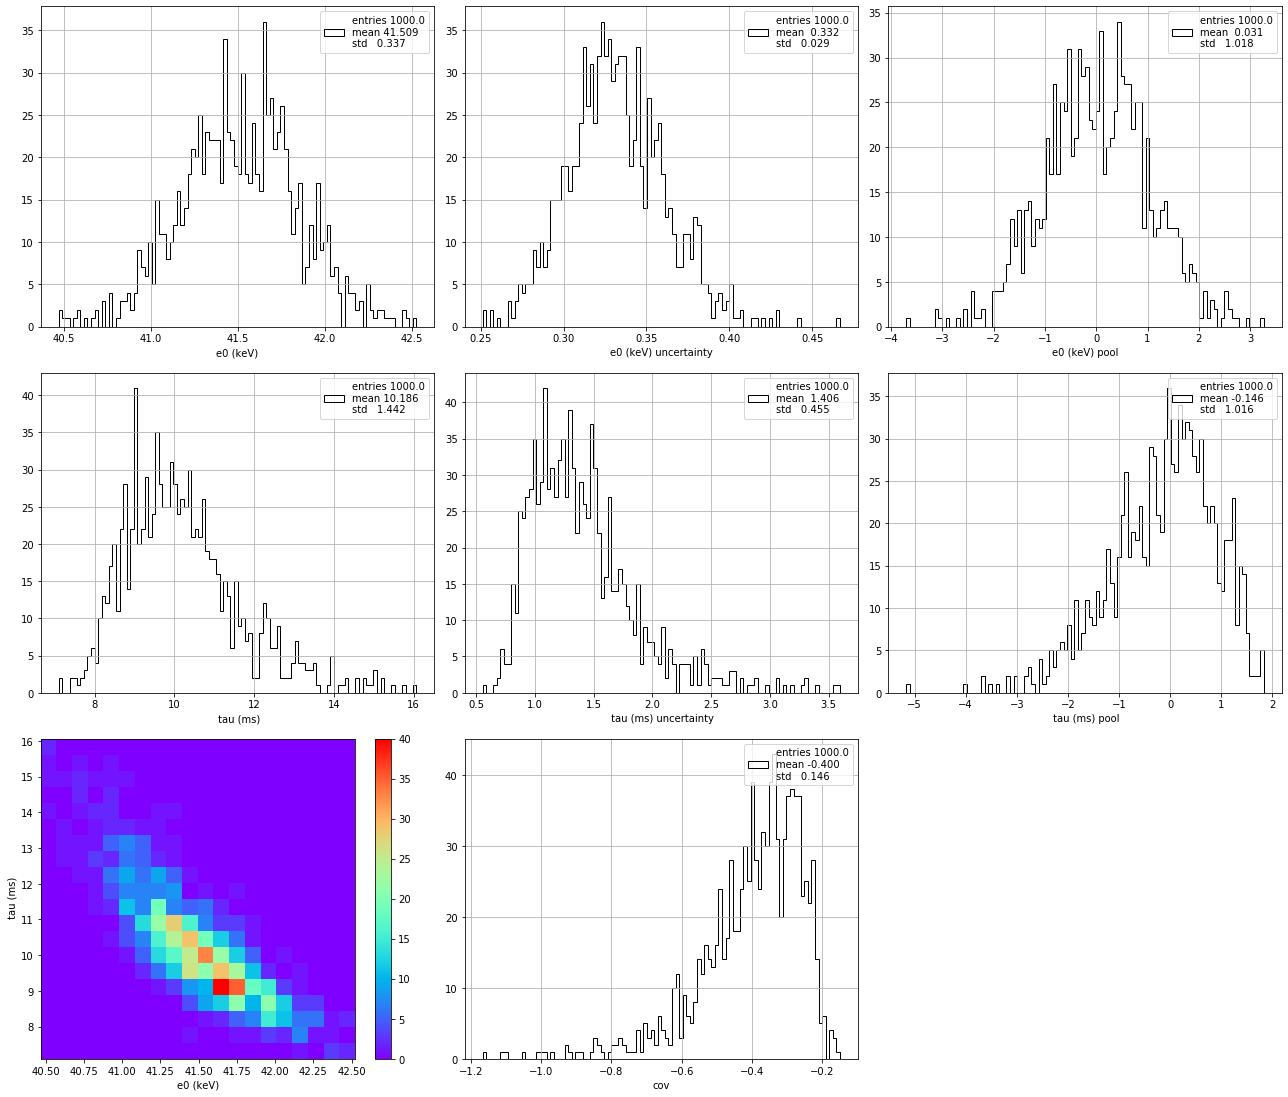

In [146]:
rs = experiments(generate_toy, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

## Attachment generator

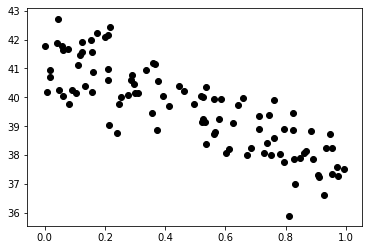

In [147]:
ts, es = generate_toy_att(size = size)
plt.scatter(ts, es);

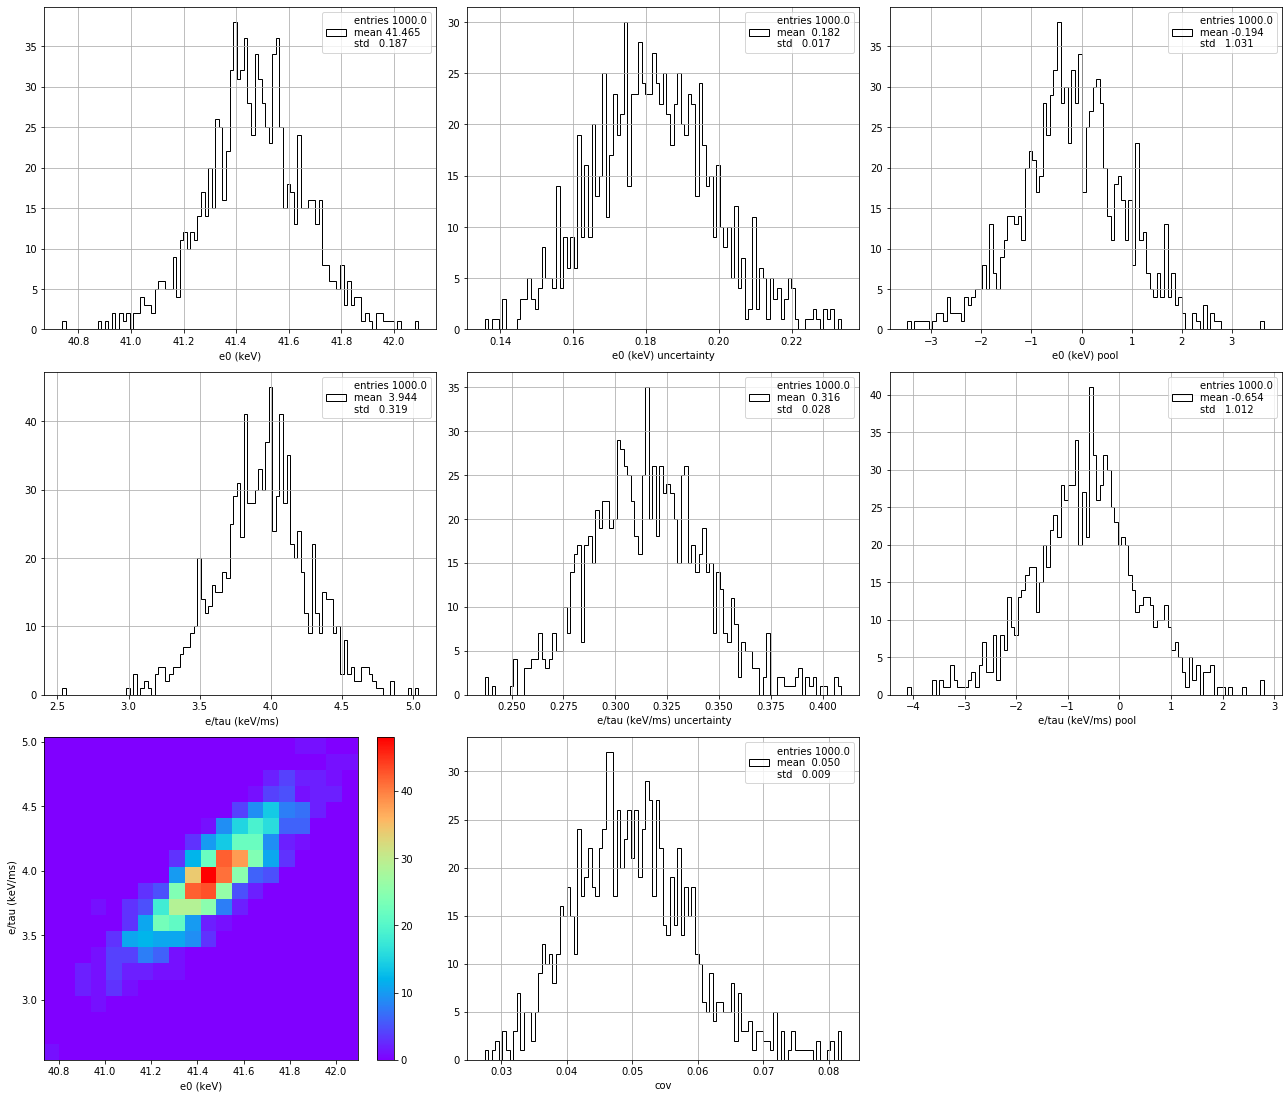

In [148]:
rs = experiments(generate_toy_att, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e/tau (keV/ms)')

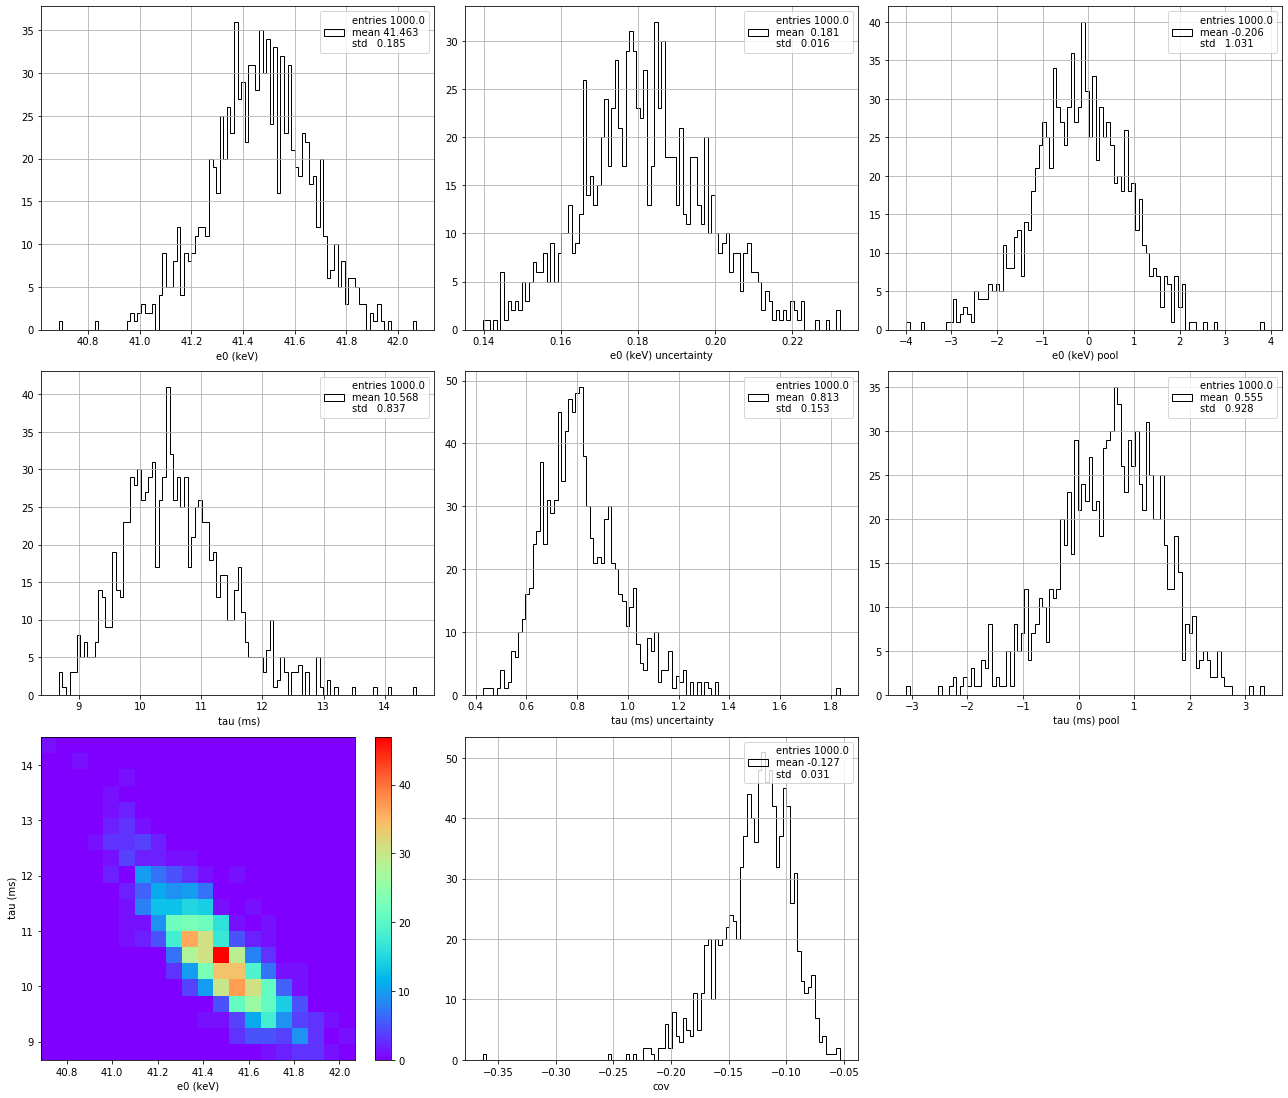

In [49]:
rs = experiments(generate_toy_att, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

## Binomial generator

(array([41.70205921,  4.28270441]), array([[0.03081666, 0.04582885],
       [0.04582885, 0.09056936]]))


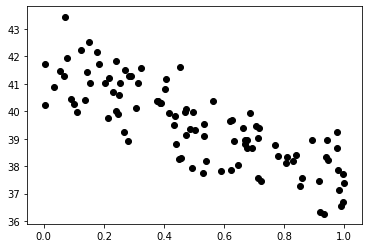

In [50]:
ts, es = generate_toy_bin(size = size)
res    = optimize.curve_fit(st_ipar, ts, es)
print(res)
plt.scatter(ts, es);

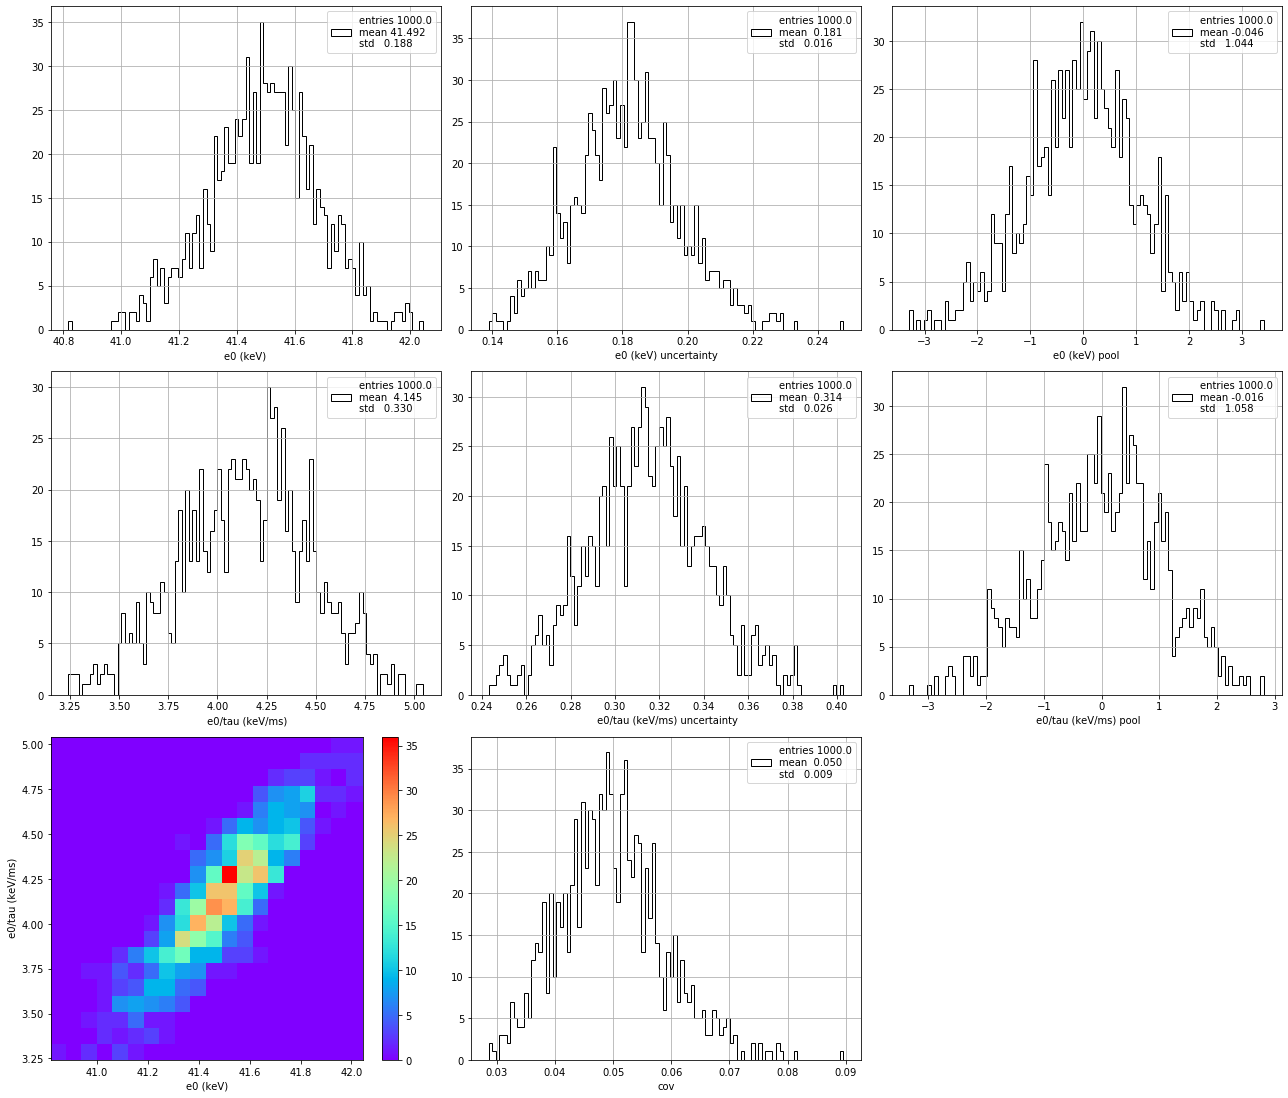

In [51]:
rs = experiments(generate_toy_bin, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e0/tau (keV/ms)')

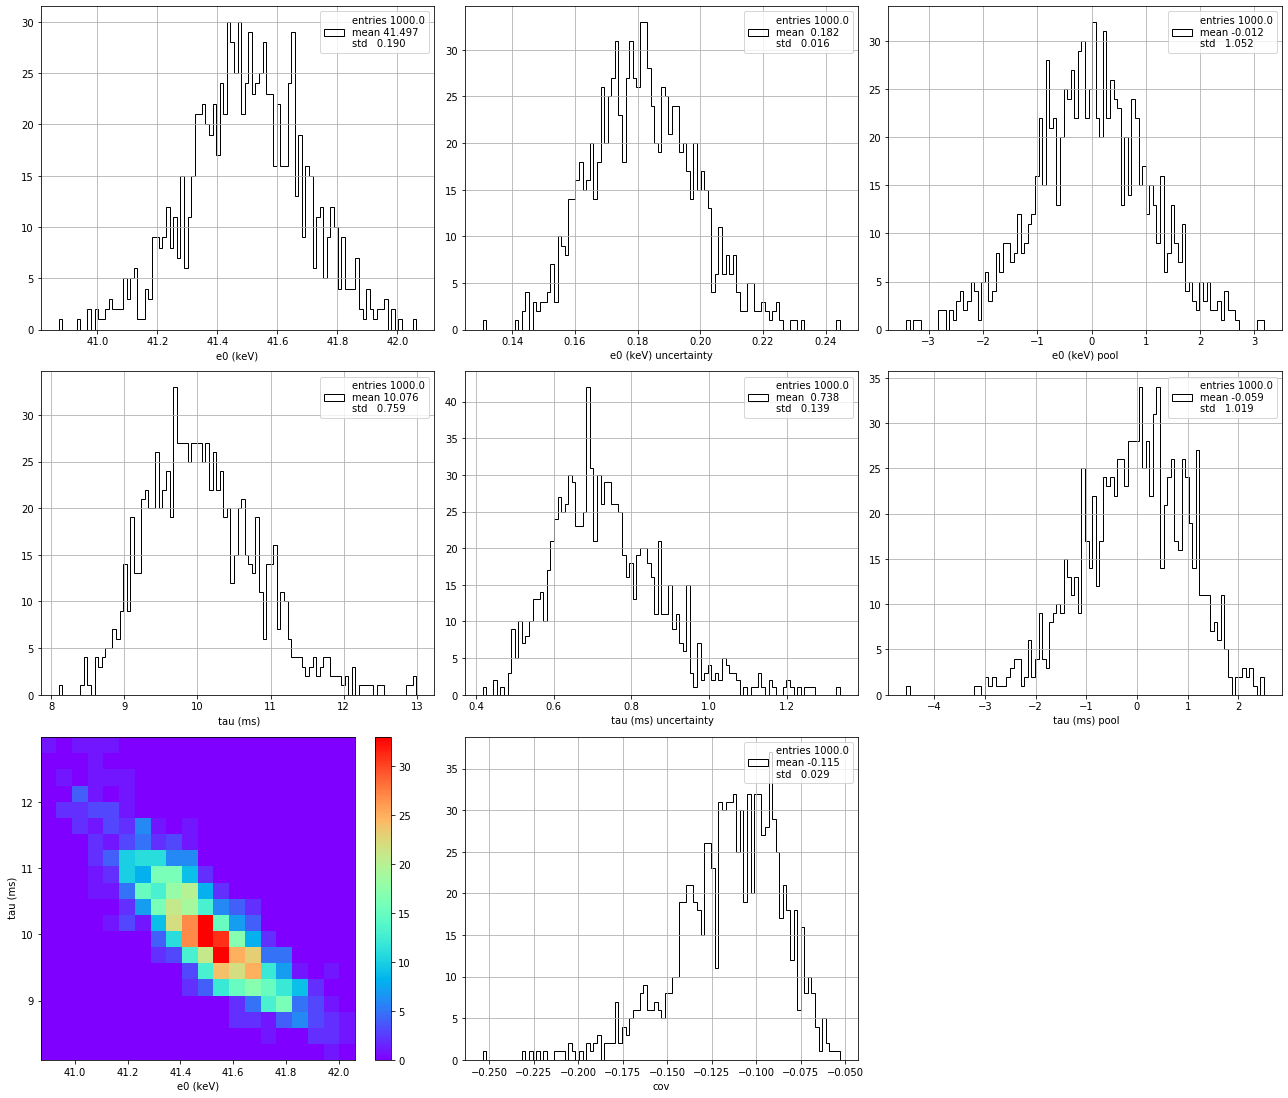

In [52]:
rs = experiments(generate_toy_bin, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

## Fit at the center of the chamber

In [67]:
st_imed = lambda t, a, b : a - b * ( t - length/2)

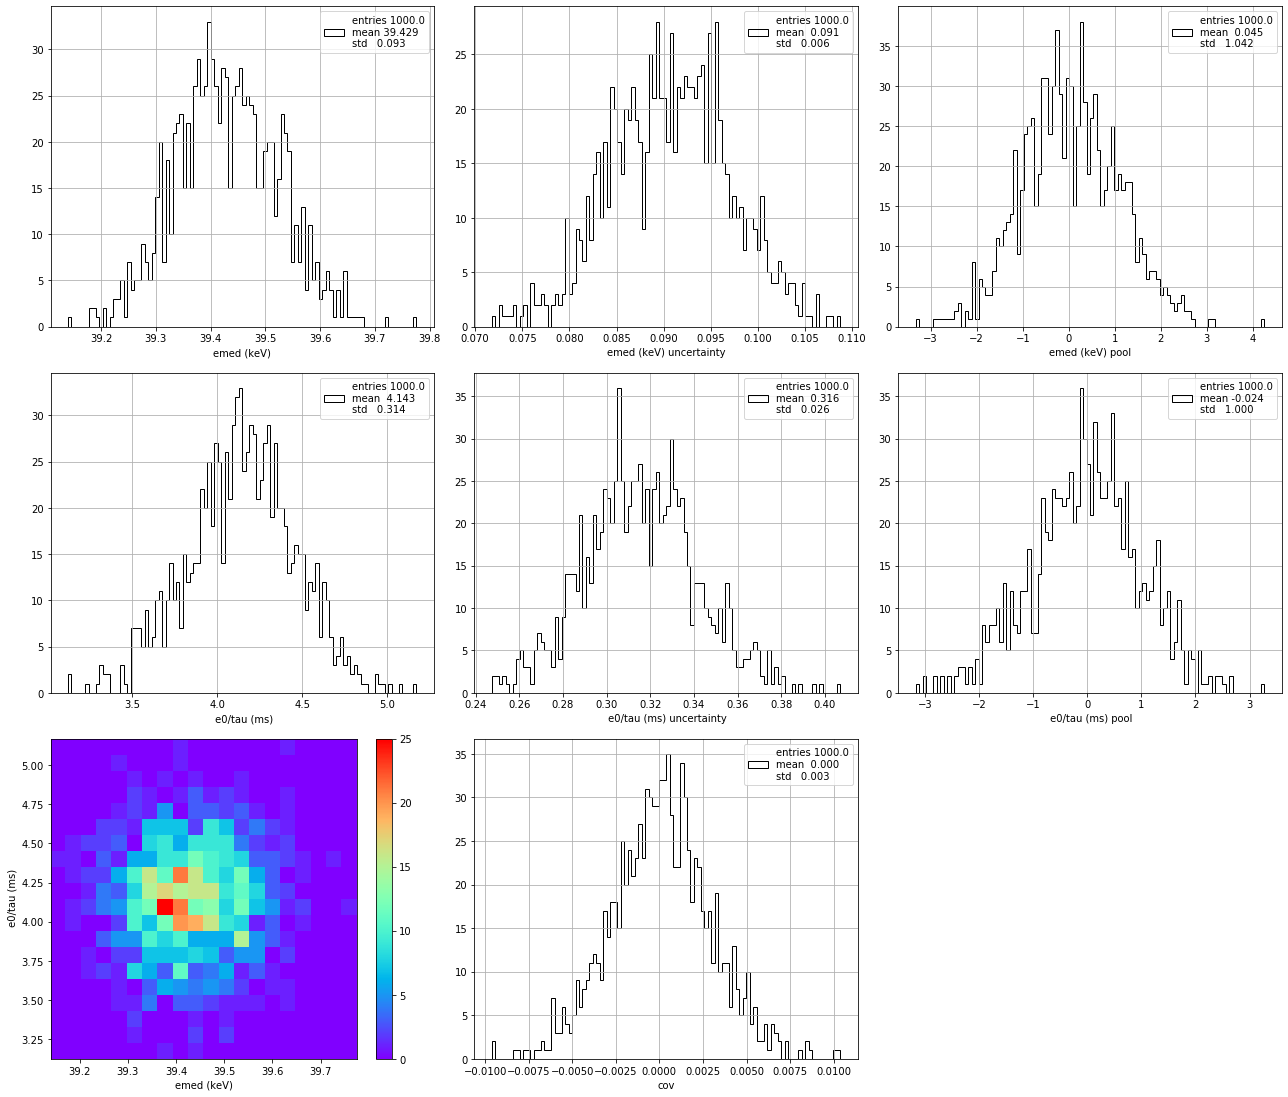

In [69]:
e0_med = e0 * (1- length/(2 * tau0))
rs = experiments(generate_toy_bin, st_imed)
plot_res(rs, e0_med, e0/tau0, 'emed (keV)', ' e0/tau (ms)')

## Test Decorrelate

In [539]:
lans, vlans = np.linalg.eig(var)
upar = np.matmul(-1. * vlans.T, par)
print(var)
print(-1. * vlans)
print(par)
print(upar)

[[0.03028868 0.04635264]
 [0.04635264 0.09798427]]
[[ 0.89155185  0.45291865]
 [-0.45291865  0.89155185]]
[41.71116268  4.43485245]
[35.17903674 22.84566442]


In [518]:
phi = np.arcsin(0.4529)

0.14961054295294837


In [519]:
-0.89 * 41.71 + 0.45 * 4.43

-35.128400000000006

In [637]:
def upars(par, var):
    lans, vlans = np.linalg.eig(var)
    #print(-1. * vlans)
    upar = np.matmul(-1. * vlans.T, (par[1], par[0]))
    return upar

In [638]:
def experiments_(generate, fun, e0 = e0, tau0 = tau0, mexp = 1000, size = 100):
    rs    = []
    for i in range(mexps):
        ts, es = generate(size = size, e0 = e0, tau0 = tau0)
        r      = optimize.curve_fit(fun, ts, es)
        #chi2   = chisq(fun, ts, es, r[0])
        rs.append((r[0], r[1], upars(*r))) 
    return rs

In [639]:
rs = experiments_(generate_toy_bin, st_ipar)

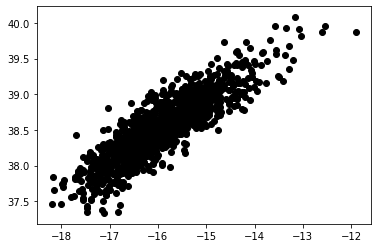

In [641]:
x0 = [r[2][0] for r in rs]
x1 = [r[2][1] for r in rs]
plt.scatter(x0, x1);

(array([41.89094101,  4.82641773]), array([[0.02180568, 0.0311494 ],
       [0.0311494 , 0.06013671]]))


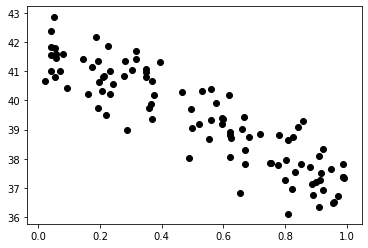

In [672]:
ts, es = generate_toy_bin(size = size)
res    = optimize.curve_fit(st_ipar, ts, es)
print(res)
plt.scatter(ts, es);

In [673]:
par, var = res
print(par)
lans, vlans = np.linalg.eig(var)
print(-1. *vlans)

[41.89094101  4.82641773]
[[ 0.87293501  0.48783652]
 [-0.48783652  0.87293501]]


In [674]:
xy = np.zeros(shape = (2, 100))
xy[0, : ] = ts
xy[1, : ] = es

In [675]:
uv = np.dot(-1. * vlans.T, xy)
us = uv[0, :]
vs = uv[1, :]

cres = optimize.curve_fit(st_ipar, us, vs) 

In [676]:
print(cres)

(array([11.56534813,  1.22963431]), array([[ 0.15206124, -0.00807823],
       [-0.00807823,  0.00043051]]))


In [657]:
cc = -1 * ( np.dot(vlans[0, :],  ts) + np.dot(vlans[1, :], es) )

ValueError: shapes (2,) and (100,) not aligned: 2 (dim 0) != 100 (dim 0)

In [653]:
print(vlans[0][1]/vlans[0][0])
print(par[0]/(20. * par[1]))


0.5152540085956144
0.4937589634382683


In [623]:
i = 1
print(np.matmul(var, vlans[:, i]/lans[i]), vlans[:, i])
print(np.dot(vlans[0], par))
print(np.dot(vlans[1], par))
print(np.dot(-1.* vlans.T, par))
print(np.dot(vlans.T, np.dot(var, vlans)))

[-0.45802859 -0.88893746] [-0.45802859 -0.88893746]
-38.56369840498454
15.173294399337365
[34.73900705 22.59621842]
[[ 7.56980304e-03 -6.93889390e-18]
 [-1.64798730e-17  1.49092457e-01]]


In [618]:
print(np.matmul(vlans[:, 0], np.array((1, 0))))
print(np.matmul(vlans[:, 1], np.array((1, 0))))

-0.88893746145193
-0.4580285904039164


In [488]:
upar = np.matmul(vlans, par)
print(upar)

[-35.17903674  22.84566442]


In [481]:
u = np.zeros(shape = (2, 2))
for i in (0, 1): u[i, :] = vlans[i]
print(u)

[[-0.89155185  0.45291865]
 [ 0.45291865  0.89155185]]


In [447]:
def residuals(ts, es, fun, pars, var):
    res  = es - fun(ts, *pars)
    size = len(ts)
    g    = np.ones(shape = (2, size))
    g[1] = ts
    a    = np.matmul(v, g)
    sig2 = a[0, :] * g[0, : ]+ a[1, :] * g[1, :]
    return res, sig2

In [448]:
rex, sig2 = residuals(ts, es, st_ipar, *res)

In [444]:
print(np.sum(rex*rex))

68.77358909545443


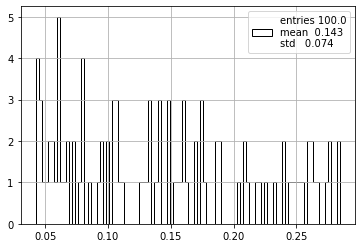

In [449]:
pltext.hist(sig2, 100);

In [389]:
v = res[1]
print(v)
g = np.ones(shape = (2, size))
g[1] = ts
print(g[:, 0].T)
a = np.matmul(v, g)
print(a.shape)
print(g.shape)
b = a[0, :] * g[0, : ]+ a[1, :] * g[1, :]
print(b.shape)
print(a[:, 0])
print(b[0])

[[0.03983719 0.06172251]
 [0.06172251 0.12296506]]
[1.         0.94695208]
(2, 100)
(2, 100)
(100,)
[0.09828545 0.17816453]
0.266998718071429


In [377]:
g0, g1        = 1., 0.94695208
v11, v22, v12 = 0.03983719, 0.12296506, 0.06172251 
a1 = g0 * v11 + g1 * v12
a2 = g0 * v12 + g1 * v22
print(a1)
print(a2)
d  = a1 * g0 + a2 * g1
print(d)

0.0982854492273208
0.1781645293343248
0.26699872086268067


In [341]:
np.matmul(g[:, 0], np.matmul(v, g[:, 0]))

0.266998718071429

In [325]:
g = np.ones(shape = (size, size))
g[..., :] = ts
g

array([[0.94695208, 0.34497752, 0.40547753, ..., 0.18726179, 0.69292249,
        0.44041327],
       [0.94695208, 0.34497752, 0.40547753, ..., 0.18726179, 0.69292249,
        0.44041327],
       [0.94695208, 0.34497752, 0.40547753, ..., 0.18726179, 0.69292249,
        0.44041327],
       ...,
       [0.94695208, 0.34497752, 0.40547753, ..., 0.18726179, 0.69292249,
        0.44041327],
       [0.94695208, 0.34497752, 0.40547753, ..., 0.18726179, 0.69292249,
        0.44041327],
       [0.94695208, 0.34497752, 0.40547753, ..., 0.18726179, 0.69292249,
        0.44041327]])

In [321]:
g = ts[np.newaxis, ts]
g.shape

IndexError: arrays used as indices must be of integer (or boolean) type

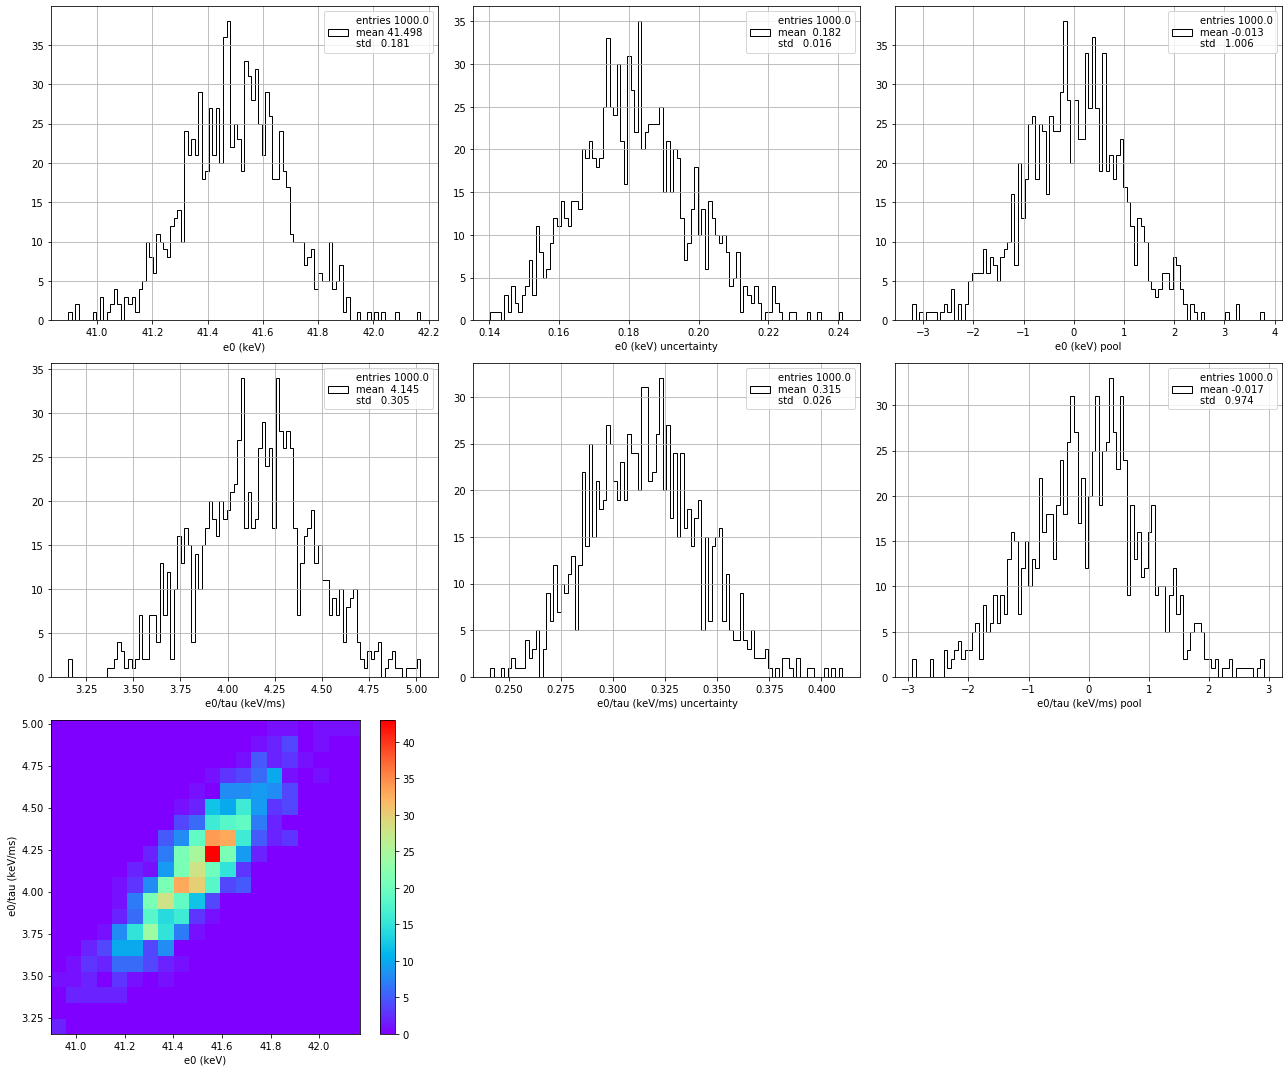

In [288]:
rs = experiments(generate_toy_bin, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e0/tau (keV/ms)')

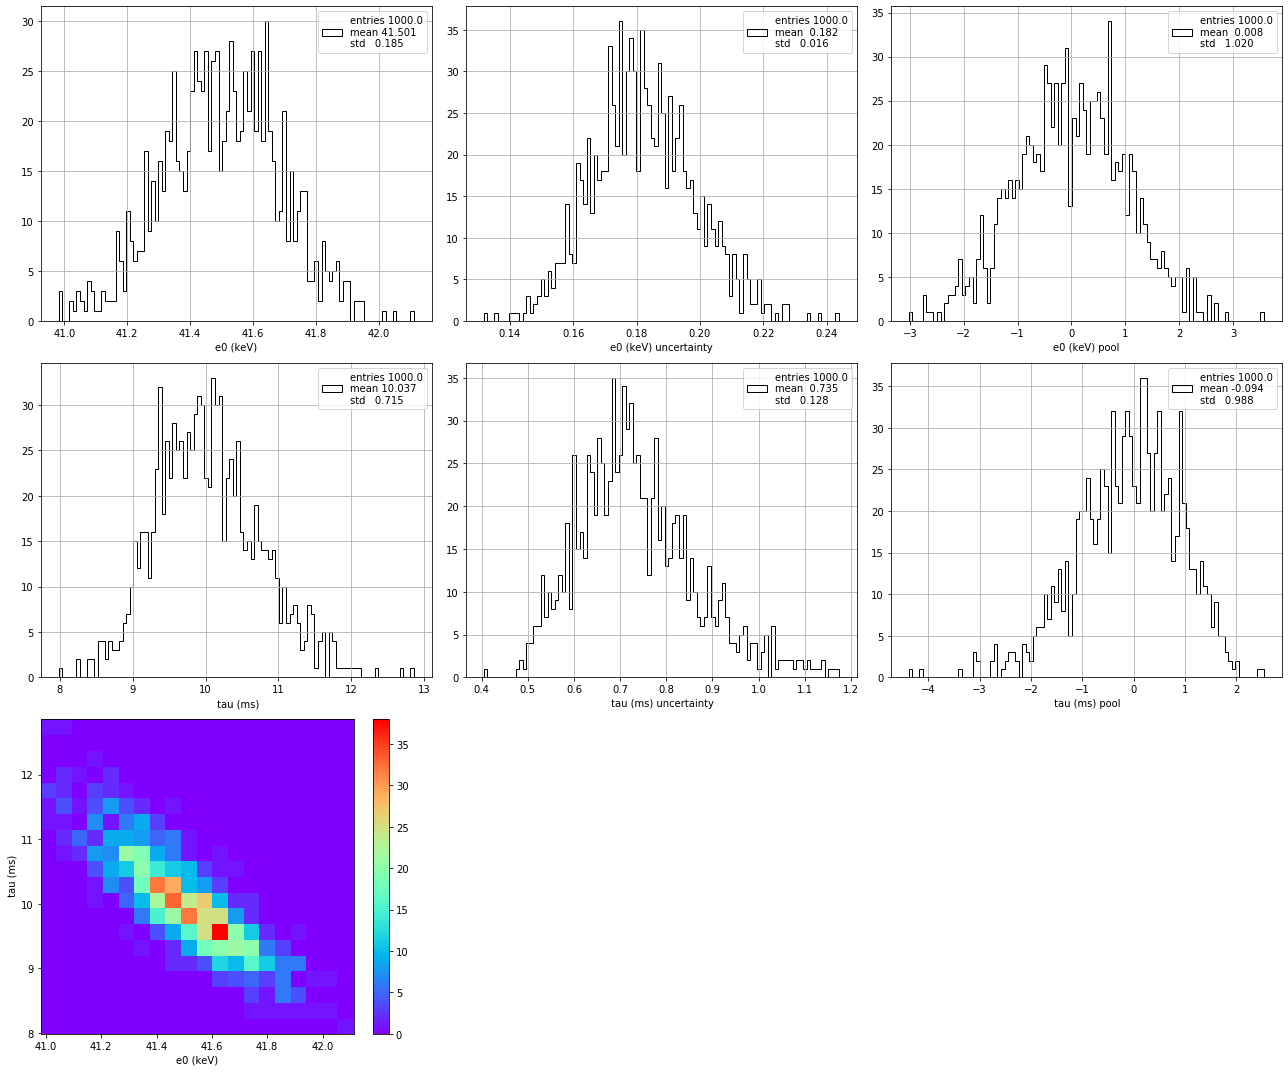

In [289]:
rs = experiments(generate_toy_bin, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

In [212]:
size     = 100
wi       = 20.75e-3
nie0     = e0/wi
print(nie0)
tis      = length * stats.uniform.rvs(size = 100)
nies     = stats.poisson.rvs(nie0, size = size)
p        = 1 - ts/tau0
nk       = stats.binom.rvs(nies, p)

2000.0


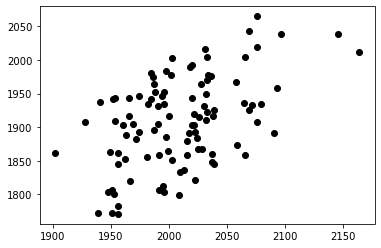

In [215]:
plt.scatter(nies, nk)

0.7504294540511545


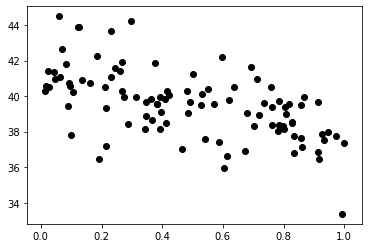

In [251]:
scale = 1.
e0, tau0, length = 41.5, 10 * scale, scale
ts, es = generate_toy(100, e0 = e0, tau0 = tau0, length = length)
print(min(es)/max(es))
plt.scatter(ts, es);

In [252]:
fun = lambda t, a0, tau : a0 * (1 - t/tau)
res = optimize.curve_fit(fun, ts, es)
print(res)

(array([41.37315372, 11.06508505]), array([[ 0.09141778, -0.38299916],
       [-0.38299916,  2.26998886]]))


In [253]:
mexps = 1000
size  = 100
rs    = []
for i in range(mexps):
    ts, es = generate_toy(100, e0 = e0, tau0 = tau0 * scale)
    res    = optimize.curve_fit(fun, ts, es)
    rs.append(res) 

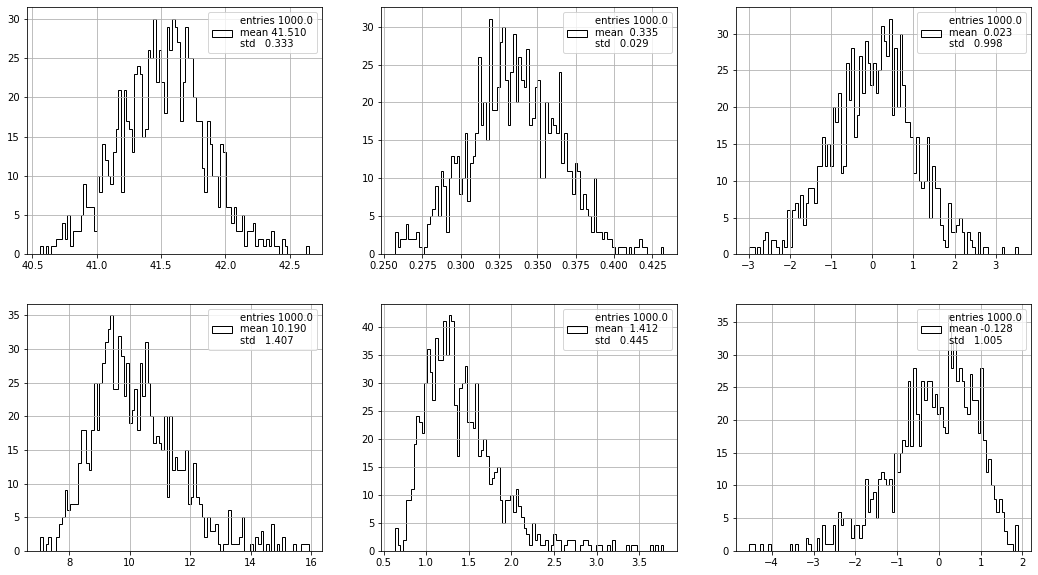

In [254]:
e0s   = np.array([r[0][0] for r in rs])
taus  = np.array([r[0][1] for r in rs])
ue0s  = np.array([np.sqrt(np.diag(r[1]))[0] for r in rs])
utaus = np.array([np.sqrt(np.diag(r[1]))[1] for r in rs])

canvas = pltext.canvas(4, 3)
canvas(1)
pltext.hist(e0s, 100);
canvas(2)
pltext.hist(ue0s, 100);
canvas(3)
pltext.hist((e0s - e0)/ue0s, 100);

canvas(4)
pltext.hist(taus, 100);
canvas(5)
pltext.hist(utaus, 100);
canvas(6)
pltext.hist((taus - tau0 )/utaus, 100);

In [155]:
fun = lambda t, alpha, beta : alpha - beta * t
res = optimize.curve_fit(fun, ts, es)
print(res)

(array([41.206584  ,  3.88814543]), array([[0.11343959, 0.16185153],
       [0.16185153, 0.31466517]]))


In [156]:
mexps = 1000
size  = 100
rs    = []
for i in range(mexps):
    ts, es = generate_toy(size = size)
    res    = optimize.curve_fit(fun, ts, es)
    rs.append(res) 

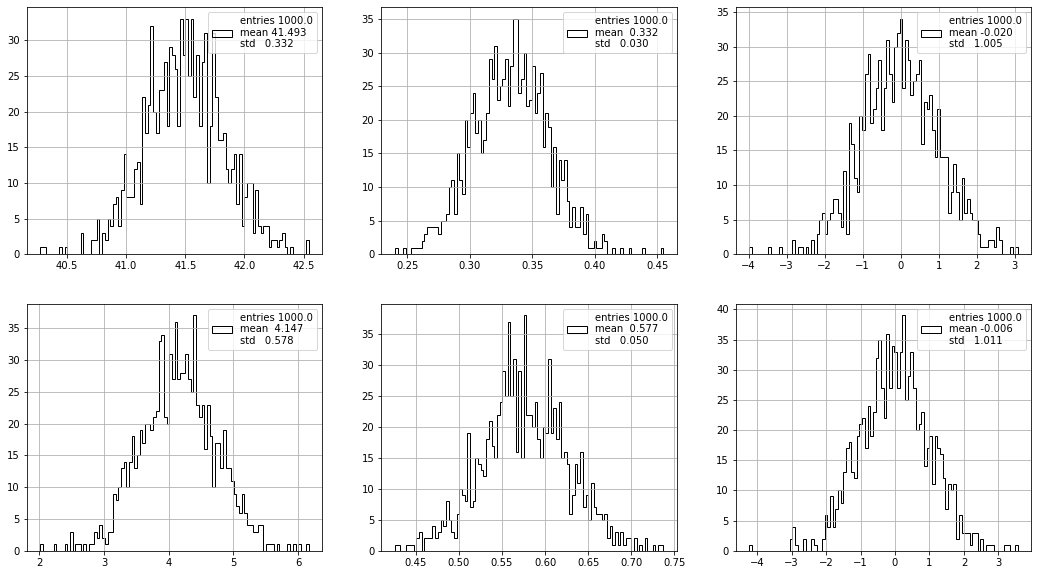

In [158]:
alphas  = np.array([r[0][0] for r in rs])
betas   = np.array([r[0][1] for r in rs])
ualphas = np.array([np.sqrt(np.diag(r[1]))[0] for r in rs])
ubetas  = np.array([np.sqrt(np.diag(r[1]))[1] for r in rs])

alpha0, beta0 = e0, e0/tau0

canvas = pltext.canvas(4, 3)
canvas(1)
pltext.hist(alphas, 100);
canvas(2)
pltext.hist(ualphas, 100);
canvas(3)
pltext.hist((alphas - alpha0)/ualphas, 100);

canvas(4)
pltext.hist(betas, 100);
canvas(5)
pltext.hist(ubetas, 100);
canvas(6)
pltext.hist((betas-beta0)/ubetas, 100);


In [170]:
@np.vectorize
def attachment(t, lifetime, n_ie):
    
    return np.count_nonzero(-lifetime * np.log(np.random.uniform(size=int(n_ie))) > t)

In [171]:
lifetime = 10
n_ie     = 2e3
tis      = length * stats.uniform.rvs(size = 100)

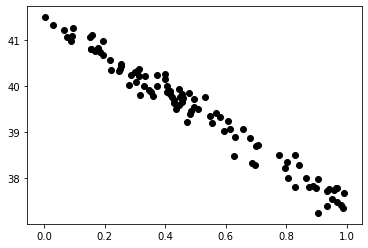

In [172]:
nis      = attachment(tis, lifetime, n_ie)
eis      = 41.5 * nis/n_ie

plt.scatter(tis, eis)

In [180]:
def generate_toy2(size = size, e0 = e0, tau0 = tau0, length = length):
    nie0     = 2e3
    tis      = length * stats.uniform.rvs(size = 100)
    nies     = stats.poisson.rvs(nie0, size = size)
    nis      = attachment(tis, tau0, nies)
    eis      = 41.5 * nis/n_ie
    return tis, eis

In [189]:
def plot_res(res, alpha0, beta0):
    alphas  = np.array([r[0][0] for r in rs])
    betas   = np.array([r[0][1] for r in rs])
    ualphas = np.array([np.sqrt(np.diag(r[1]))[0] for r in rs])
    ubetas  = np.array([np.sqrt(np.diag(r[1]))[1] for r in rs])

    
    canvas = pltext.canvas(4, 3)
    canvas(1)
    pltext.hist(alphas, 100);
    canvas(2)
    pltext.hist(ualphas, 100);
    canvas(3)
    pltext.hist((alphas - alpha0)/ualphas, 100);

    canvas(4)
    pltext.hist(betas, 100);
    canvas(5)
    pltext.hist(ubetas, 100);
    canvas(6)
    pltext.hist((betas-beta0)/ubetas, 100);
    plt.tight_layout()


0.839458413926499


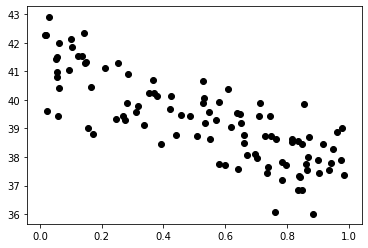

In [190]:
scale = 1.
e0, tau0, length = 41.5, 10 * scale, scale
ts, es = generate_toy2(size = 100, e0 = e0, tau0 = tau0, length = length)
print(min(es)/max(es))
plt.scatter(ts, es);

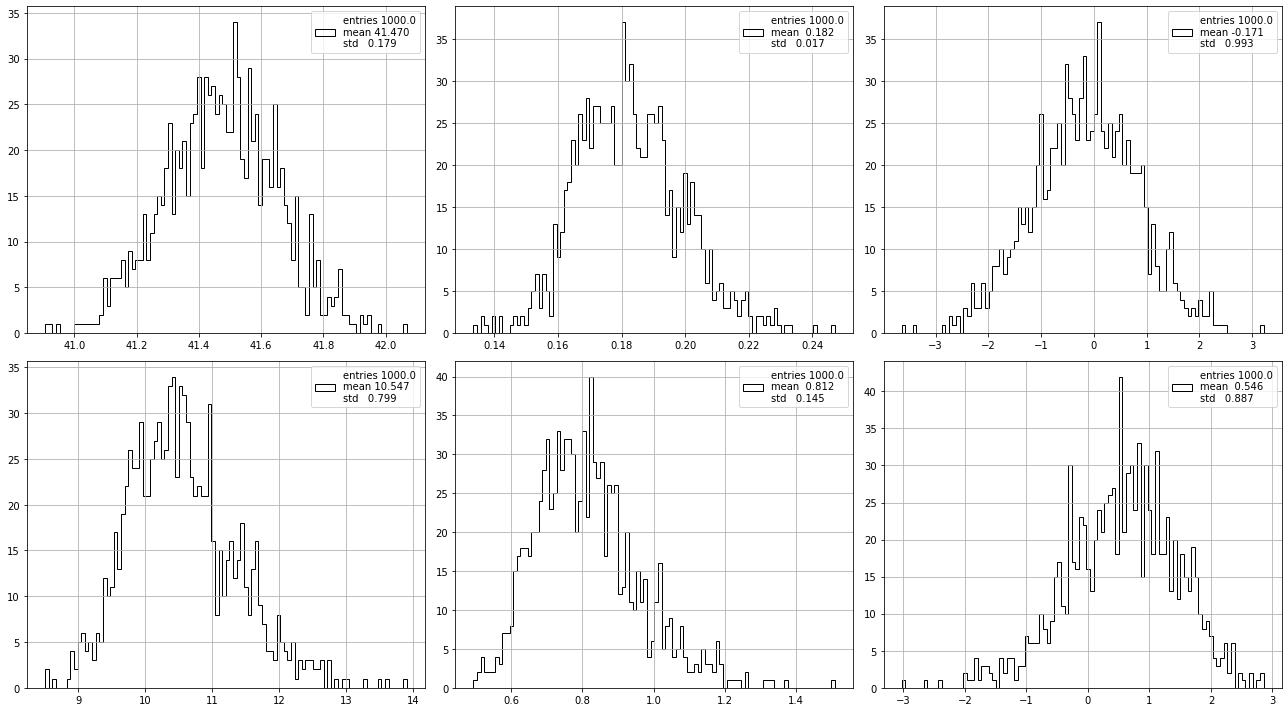

In [191]:
plot_res(res, e0, tau0)

In [192]:
def experiments(generate, fund, msize = 1000, size = 100):
    rs    = []
    for i in range(mexps):
        ts, es = generate(size = size)
        res    = optimize.curve_fit(fun, ts, es)
        rs.append(res) 
    return rs

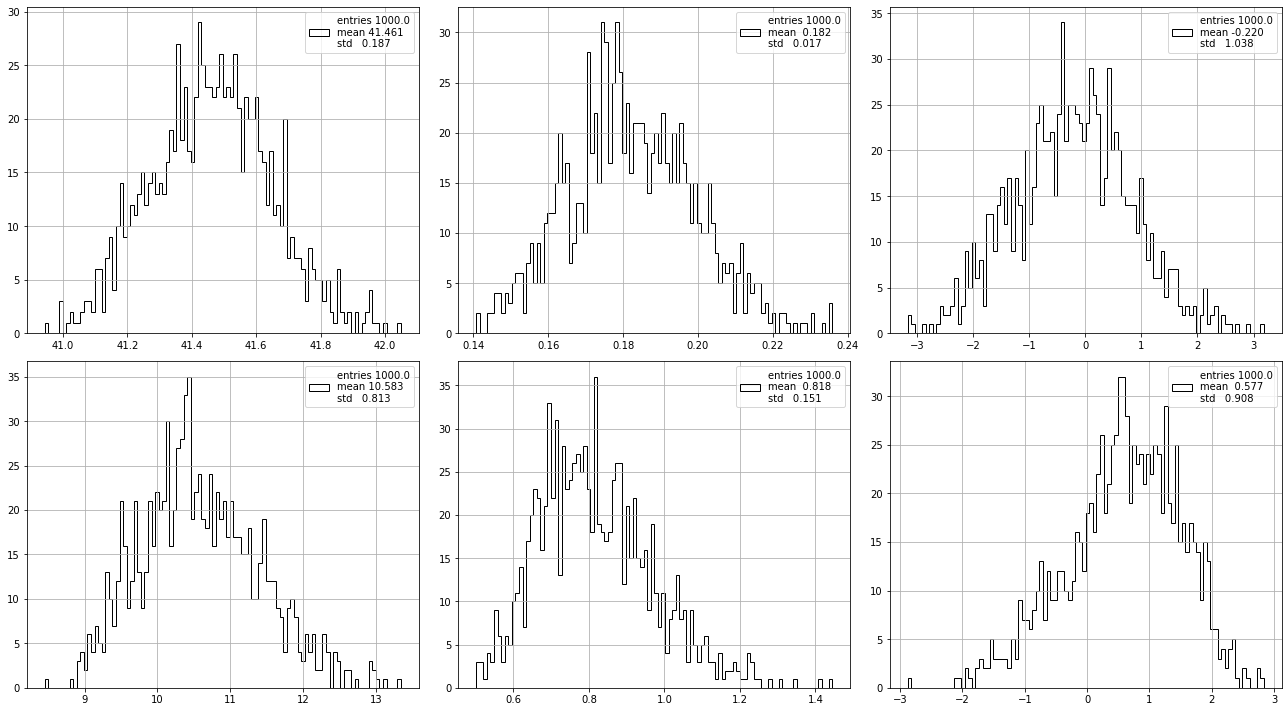

In [195]:
e0, tau0 = 41.5, 10.
fun = lambda t, e0, tau : e0 * (1 - t/tau)
rs = experiments(generate_toy2, fun)
plot_res(rs, e0, tau0)

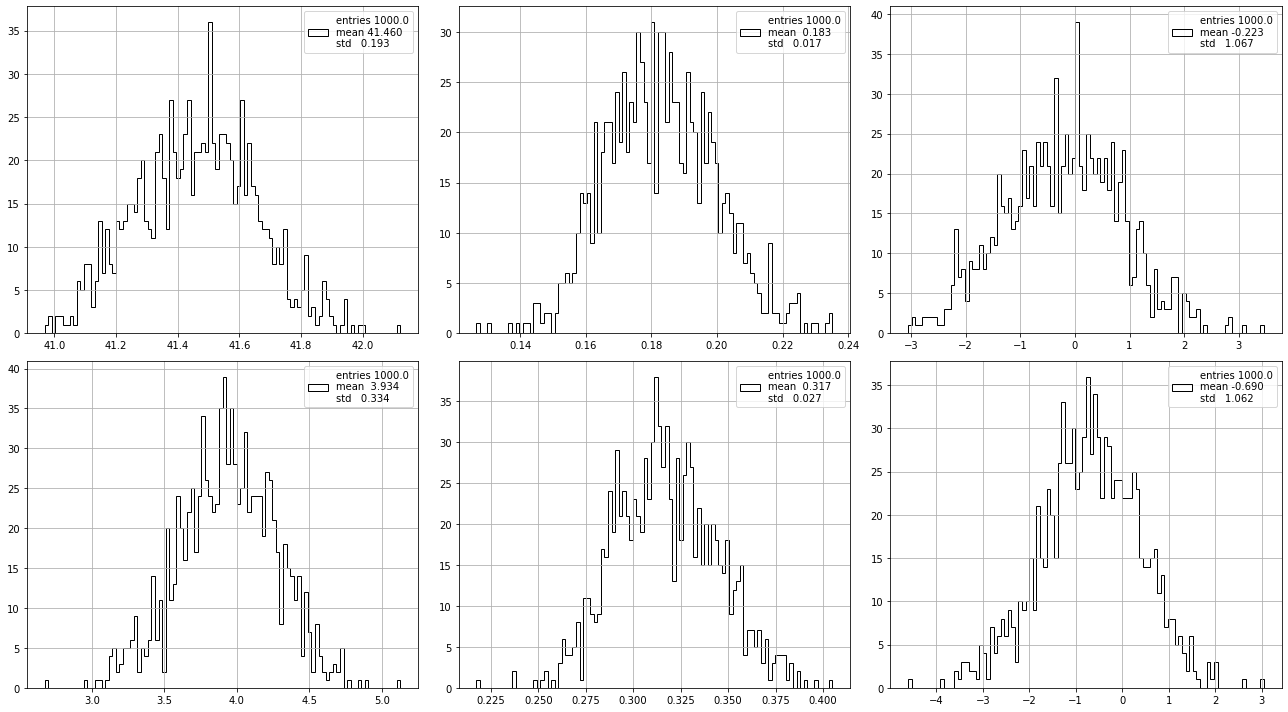

In [197]:
e0, tau0 = 41.5, 10.
fun = lambda t, alpha, beta : alpha - beta * t
rs = experiments(generate_toy2, fun)
plot_res(rs, e0, e0/tau0)

In [6]:
def generate_kr_toy(size = 100000, length = 100., e0 = 41.5, tau = 0.1, beta = 0.2, sigma = 0.05):
    """
    Generate Kr data: x, y, z, enegy
    """
    
    ts = stats.uniform.rvs(0, length, size = size)
    xs = stats.uniform.rvs(0, length, size = size) - 0.5 * length
    ys = stats.uniform.rvs(0, length, size = size) - 0.5 * length
    es = (1. - tau * ts/length) * stats.norm.rvs(loc = e0, scale = e0 * sigma, size = size)
    rs = np.sqrt(xs ** 2 + ys ** 2)
    er = es * (1 - beta * (2 * rs / length) ** 2)
    
    sel = rs < length/2
    df = {'dtime' : ts[sel], 'x': xs[sel], 'y': ys[sel], 'energy': er[sel]}
    return pd.DataFrame(df)
                                               

In [10]:
def plot_data(df):
    """
    Plot Kr Data
    """
    canvas = pltext.canvas(6, 2)
    canvas(1)
    pltext.hist(df.dtime, 100);
    plt.xlabel('drift time (ms)')
    canvas(2)
    pltext.hist(df.x, 100);
    plt.xlabel('x (mm)')
    canvas(3)
    pltext.hist(df.y, 100);
    plt.xlabel('y (mm)')
    canvas(4)
    pltext.hist(df.energy, 100);
    plt.xlabel('energy (keV)')
    canvas(5)
    plt.hist2d(df.dtime, df.energy, (20, 20))
    plt.xlabel('drift time (ms)'); plt.ylabel('energy (keV)')
    plt.colorbar();
    canvas(6)
    mean, ebins, _  = stats.binned_statistic_dd((df.x, df.y), df.energy, bins = 20 , statistic = 'mean')
    cbins = [0.5 * (b[1:] + b[:-1]) for b in ebins]
    mesh = np.meshgrid(*cbins)
    plt.hist2d(mesh[0].ravel(), mesh[1].ravel(), bins = ebins, weights = mean.T.ravel())
    plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.title('energy (keV)')
    plt.colorbar();
    plt.tight_layout();

## 1D 

In [11]:
df = generate_kr_toy(100000, tau = 0.1, beta = 0.)
df

,dtime,x,y,energy
0,11.953657,34.946003,-18.243082,40.243767
1,91.709194,-3.457280,33.792103,36.382221
2,26.824165,30.821546,10.920230,41.871340
3,20.137469,-5.194273,-2.998603,39.266211
4,61.335084,-48.081427,-11.238924,35.217677
...,...,...,...,...
78357,76.261862,1.801539,-16.109894,39.617190
78358,99.423565,21.851185,-27.425888,33.807476
78359,38.514650,-10.143240,31.329799,43.584979
78360,0.258530,-28.915267,12.639966,39.853698


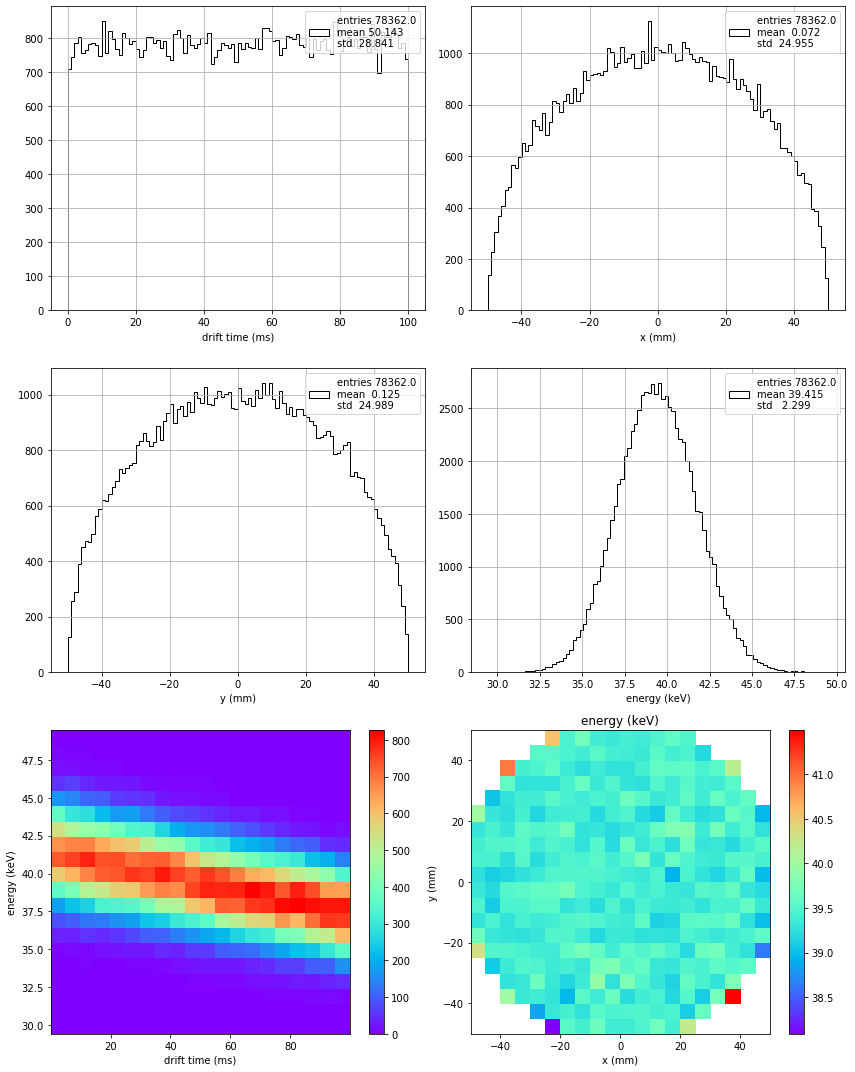

In [12]:
plot_data(df)

In [13]:
coors  = (df.dtime.values,)
energy = df.energy.values
bins   = 100
krmap  = prof.profile(coors, energy, bins)

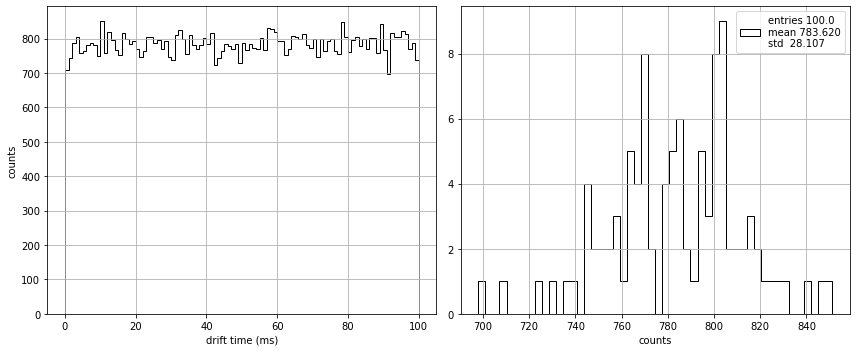

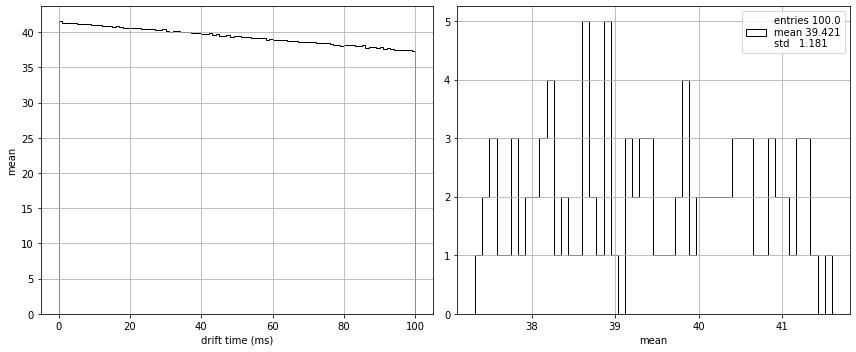

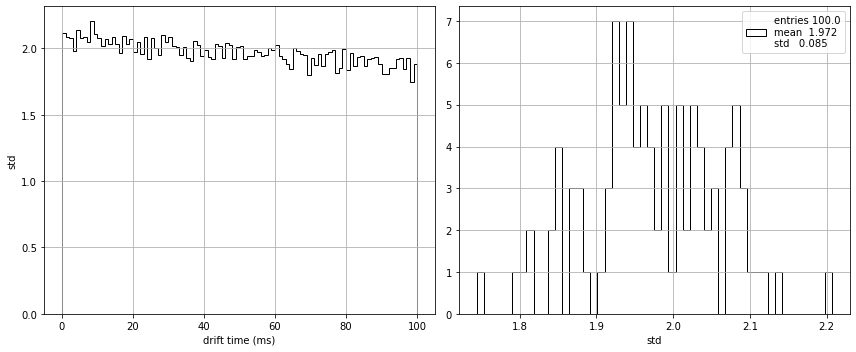

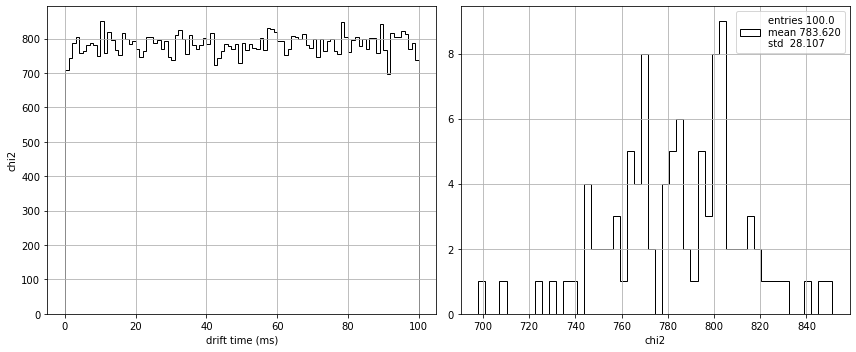

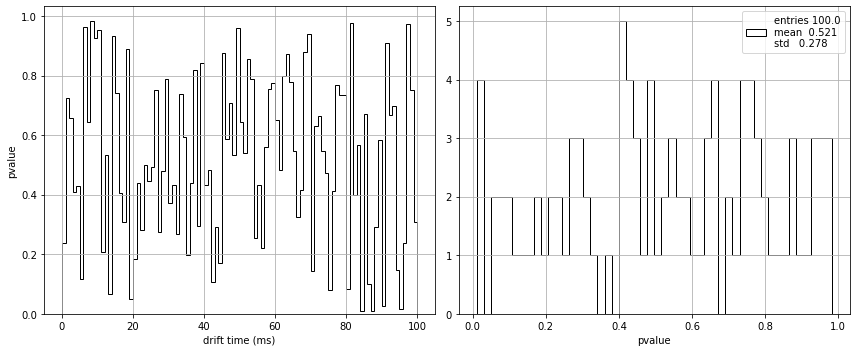

In [14]:
prof.plot_profile(krmap)

### correction

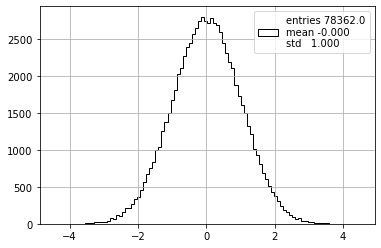

In [15]:
pltext.hist(krmap.residuals, 100);

In [16]:
corenergy = prof.profile_scale(coors, energy, krmap)
corkrmap  = prof.profile(coors, corenergy, bins)

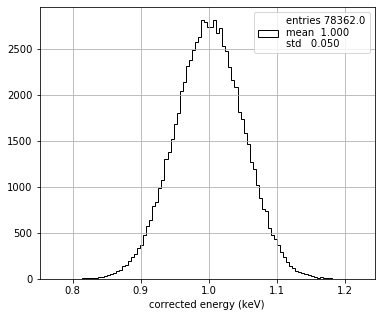

In [17]:
pltext.canvas(1, 1)
pltext.hist(corenergy, 100);
plt.xlabel('corrected energy (keV)');

### Validate correction

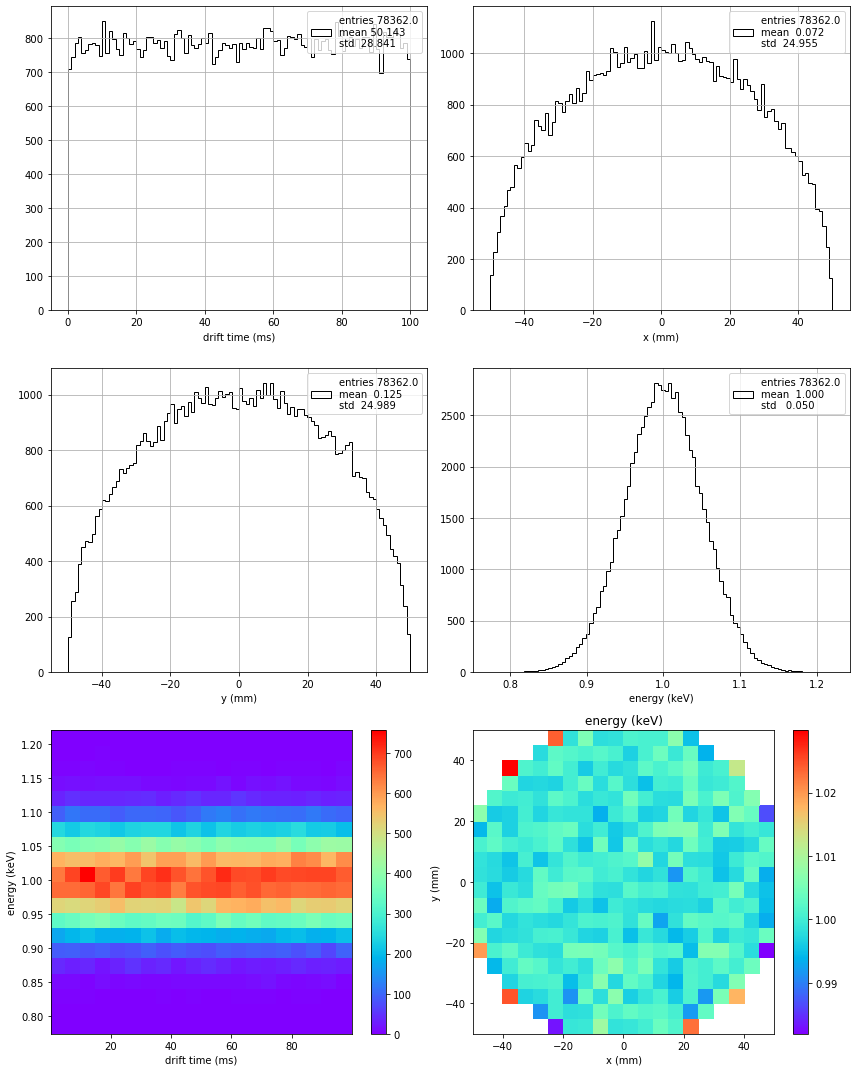

In [18]:
xdf = pd.DataFrame(df) 
xdf['energy'] = corenergy
plot_data(xdf)

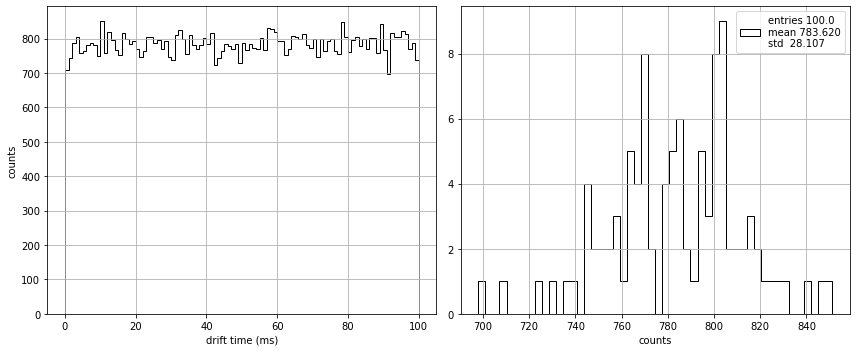

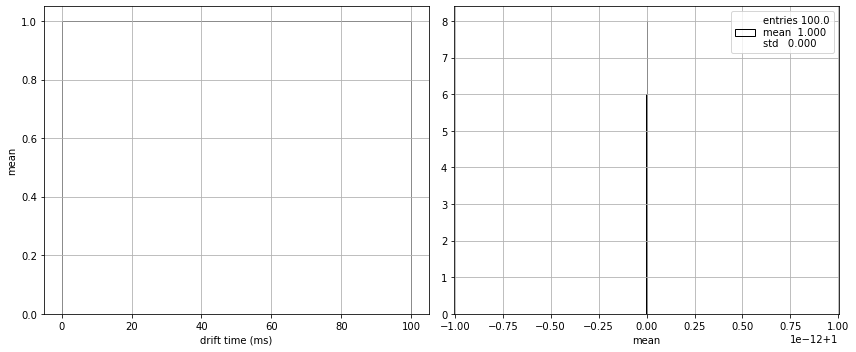

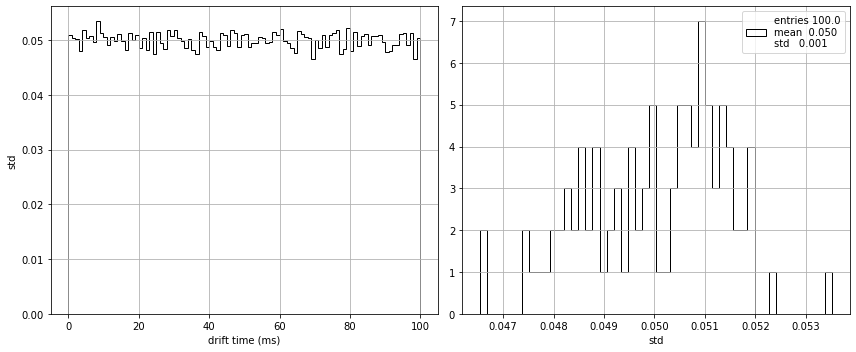

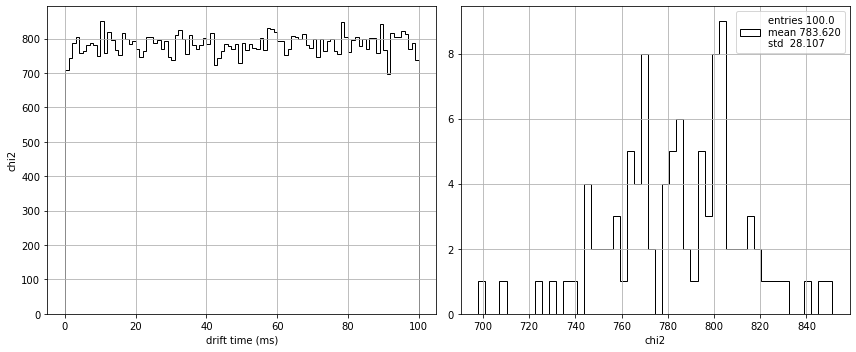

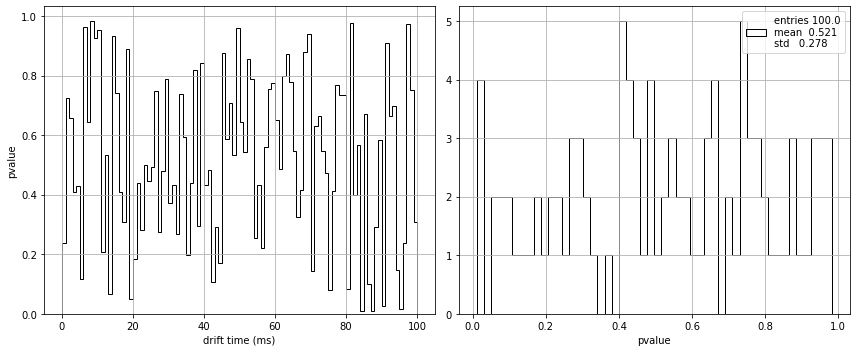

In [19]:
prof.plot_profile(corkrmap)

## 2D

In [20]:
df = generate_kr_toy(100000, tau = 0., beta = 0.2)
df

,dtime,x,y,energy
0,60.403911,46.519725,18.139539,30.794081
1,95.065599,-18.992161,-18.891863,39.956533
2,65.500413,35.066610,1.747699,38.228443
3,15.109601,8.064602,33.666721,34.914163
4,65.154867,2.060481,-6.561552,39.857338
...,...,...,...,...
78588,96.179668,-36.987658,10.890777,35.200717
78589,40.236846,-13.343778,-42.047165,33.144345
78590,11.207273,-24.809540,-19.147713,38.568662
78591,7.056227,-20.051644,3.181587,41.636034


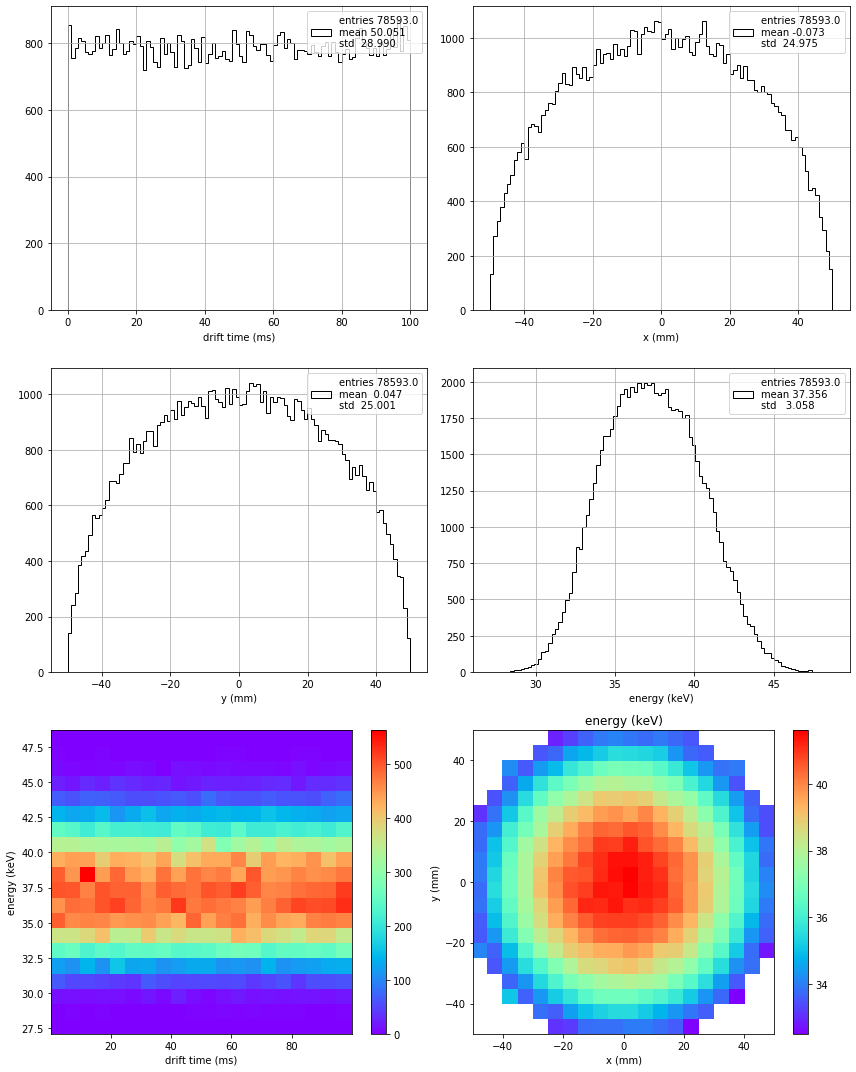

In [21]:
plot_data(df)

### kr  map

In [22]:
coors  = (df.x.values, df.y.values)
energy = df.energy.values
bins   = 40, 40
krmap  = prof.profile(coors, energy, bins)

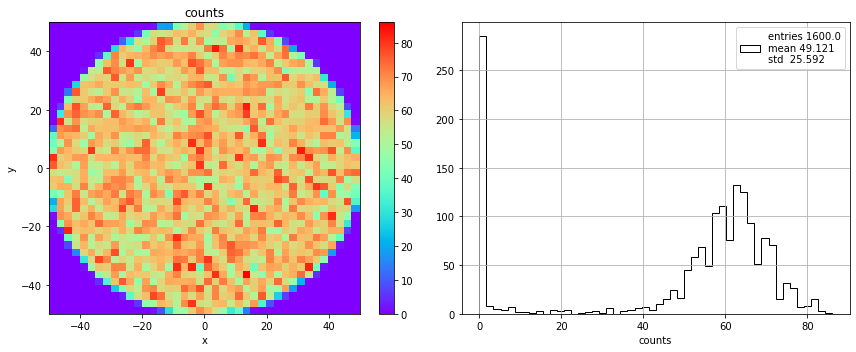

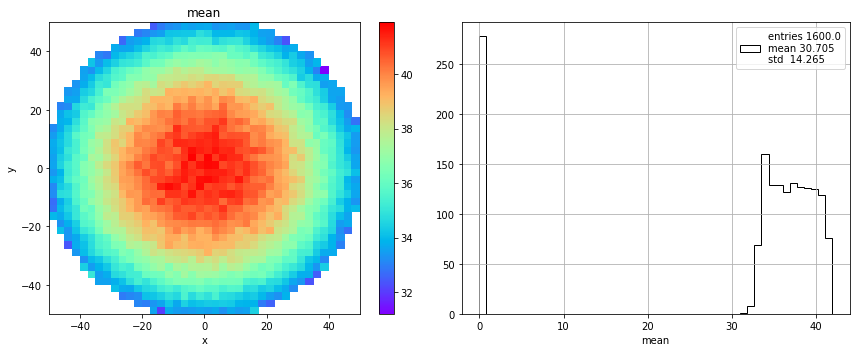

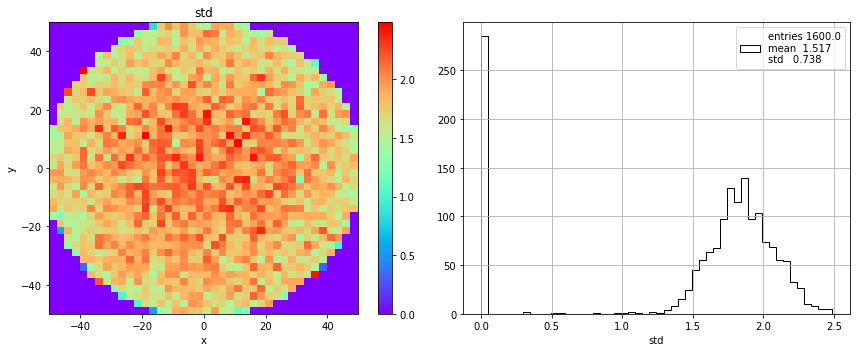

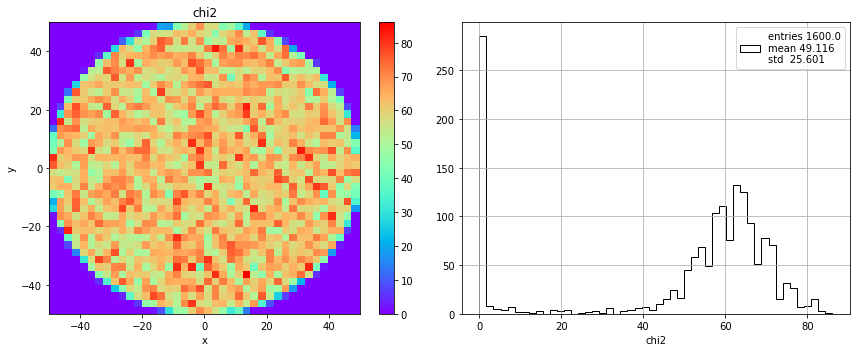

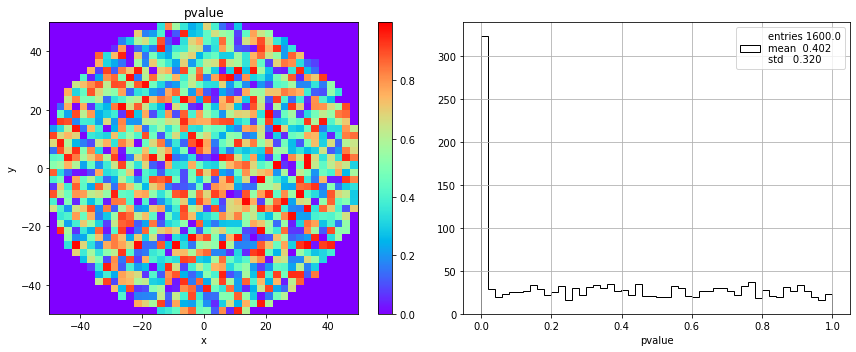

In [23]:
prof.plot_profile(krmap)

### Correction

In [24]:
corenergy = prof.profile_scale(coors, energy, krmap)
corkrmap  = prof.profile(coors, corenergy, bins)

Text(0.5, 0, 'corrected energy (keV)')

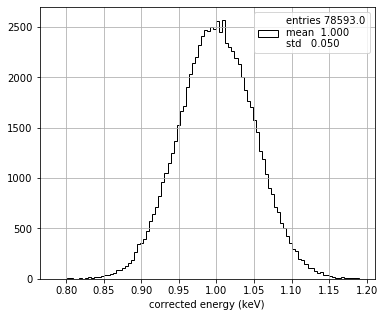

In [25]:
pltext.canvas(1, 1)
pltext.hist(corenergy, 100);
plt.xlabel('corrected energy (keV)')

### Validate correction

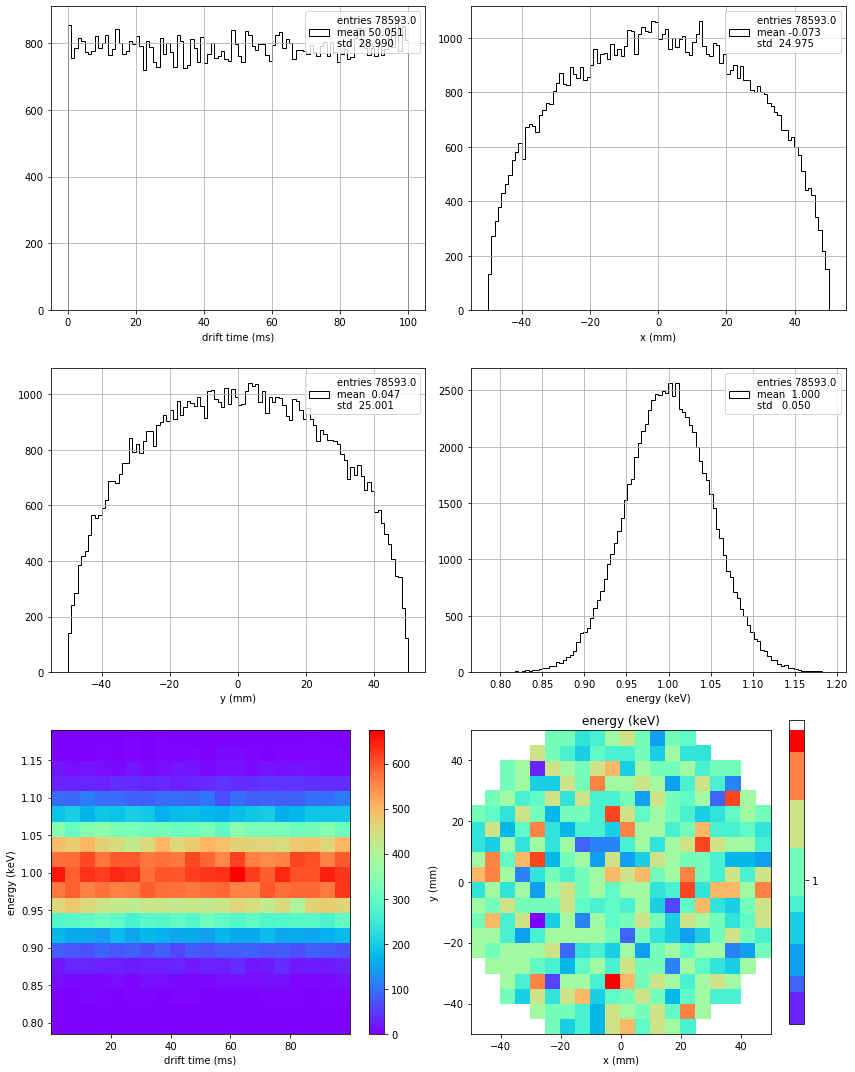

In [26]:
xdf = pd.DataFrame(df) 
xdf['energy'] = corenergy
plot_data(xdf)

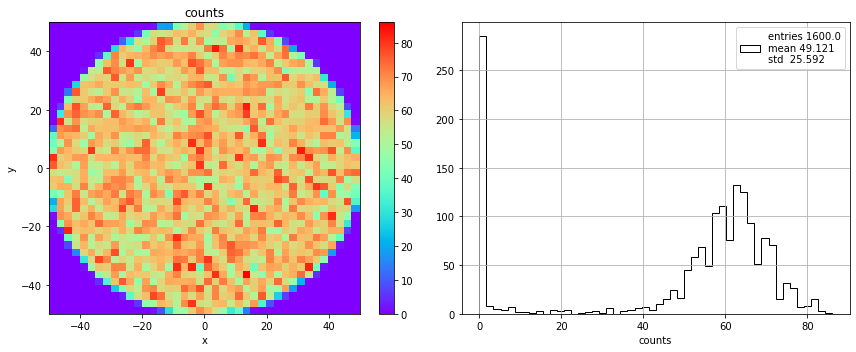

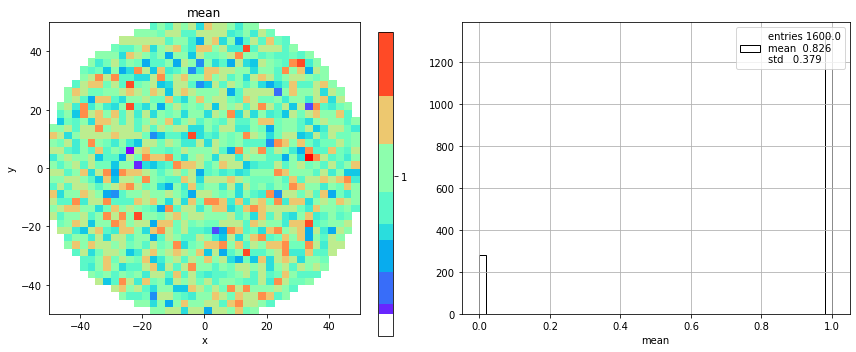

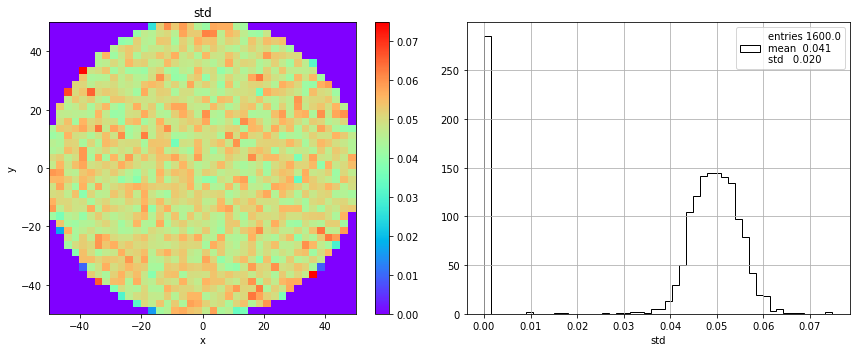

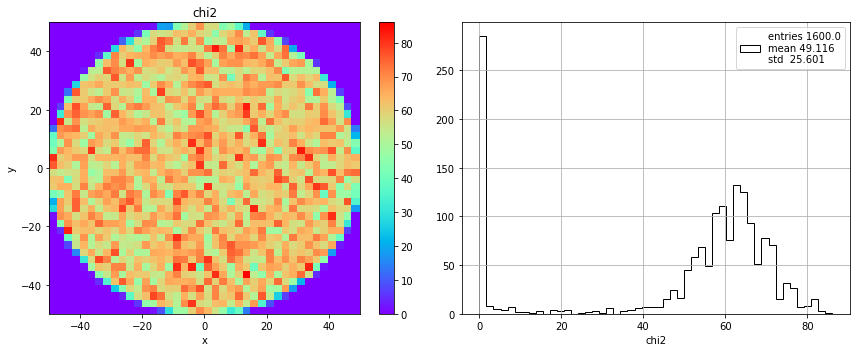

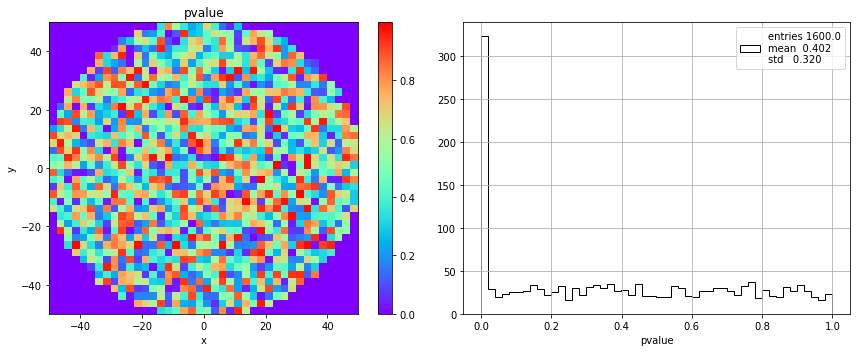

In [27]:
prof.plot_profile(corkrmap)

## 3D

In [28]:
df = generate_kr_toy(100000, tau = 0.1, beta = 0.2)
df

,dtime,x,y,energy
0,39.371252,29.799199,8.974739,34.564934
1,84.666853,-1.094647,15.498186,40.347027
2,88.066336,-2.685729,29.873562,32.875105
3,8.234180,15.251645,-7.733324,40.556672
4,85.593832,14.915284,-19.692291,36.481908
...,...,...,...,...
78471,32.715351,34.478531,-32.896780,33.588935
78472,28.299843,-29.344590,-20.966402,36.933033
78473,11.359552,41.195924,-16.724179,34.730171
78474,23.112804,18.617547,35.347318,34.934348


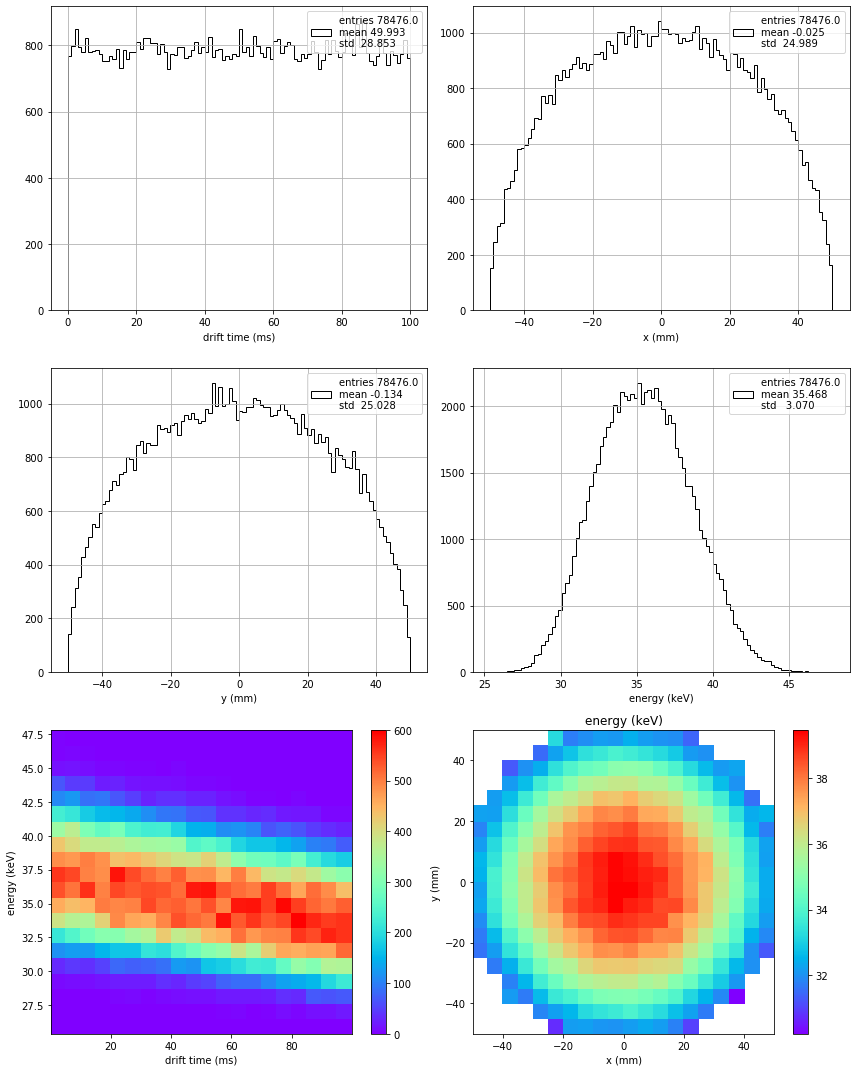

In [29]:
plot_data(df)

### Kr map

In [30]:
coors  = (df.x.values, df.y.values, df.dtime.values)
energy = df.energy.values
bins   = 20, 20, 4
krmap  = prof.profile(coors, energy, bins)

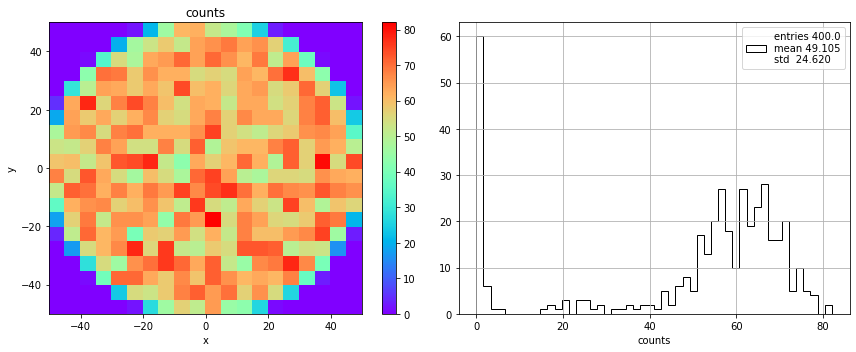

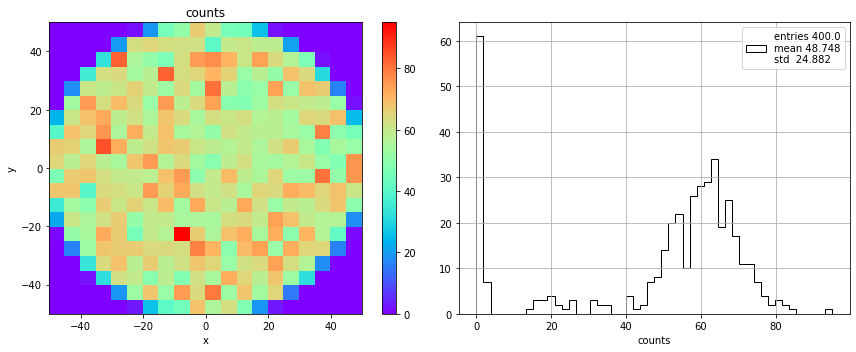

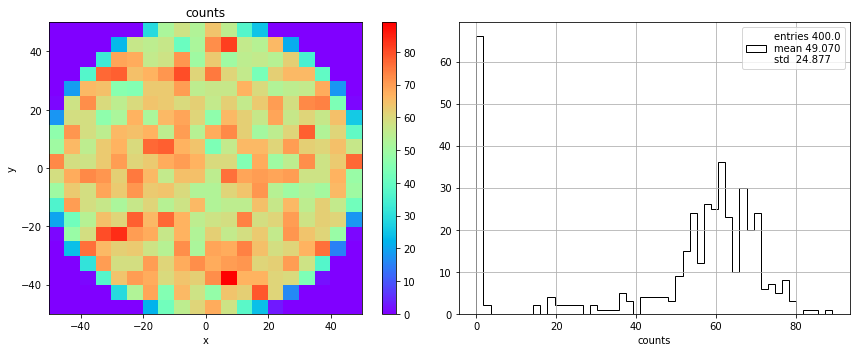

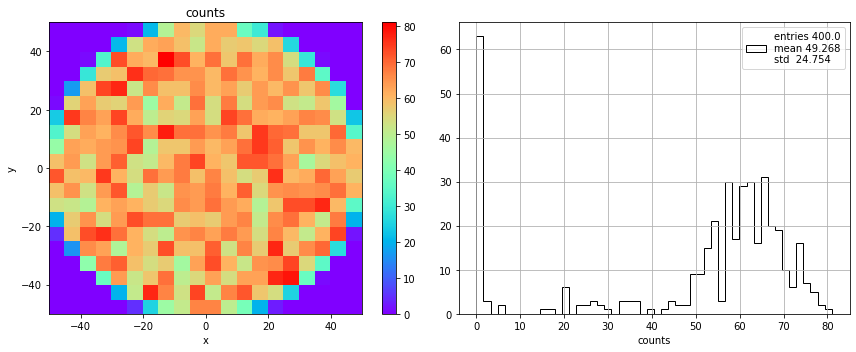

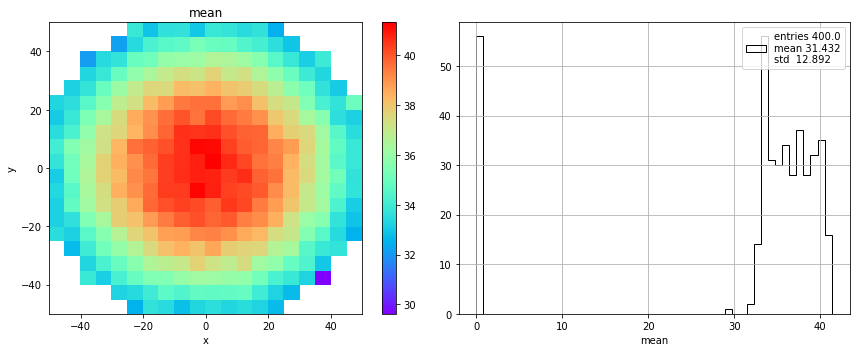

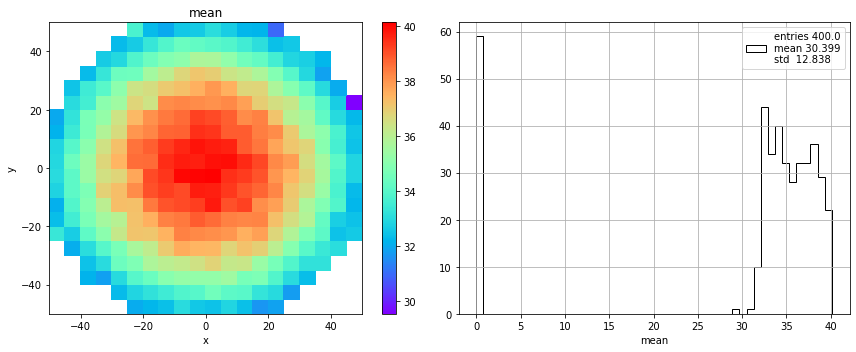

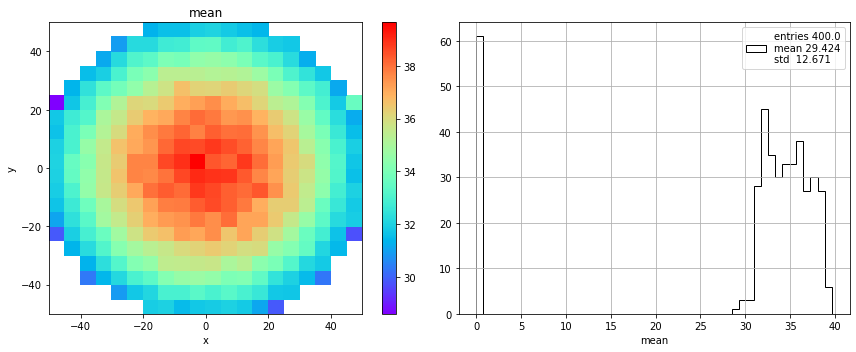

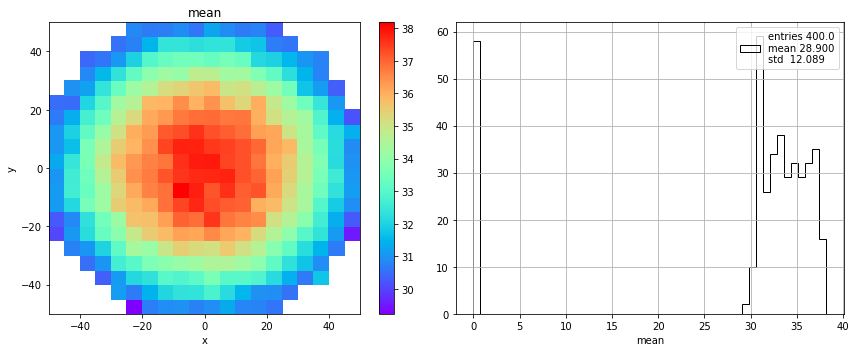

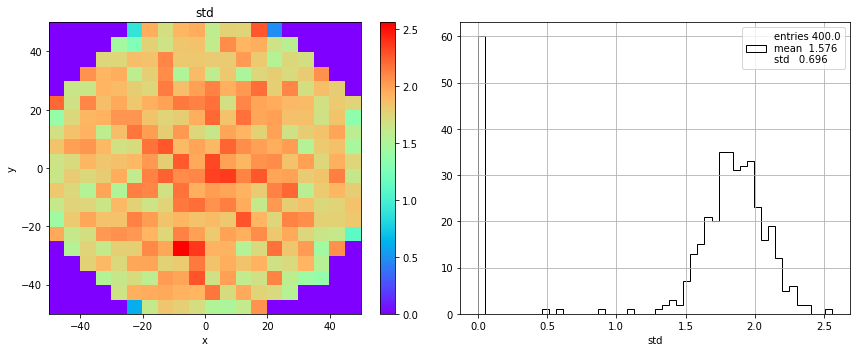

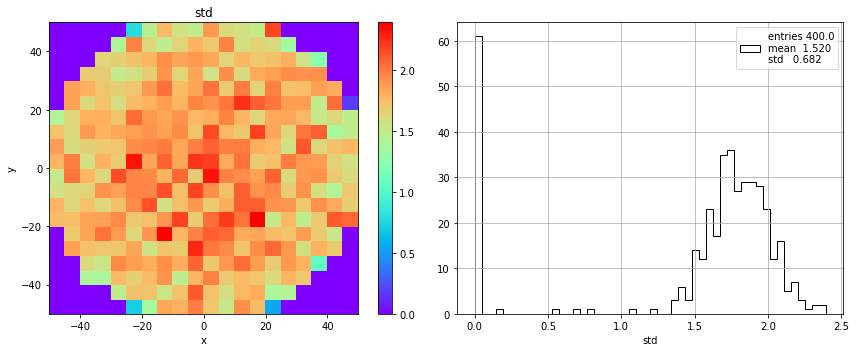

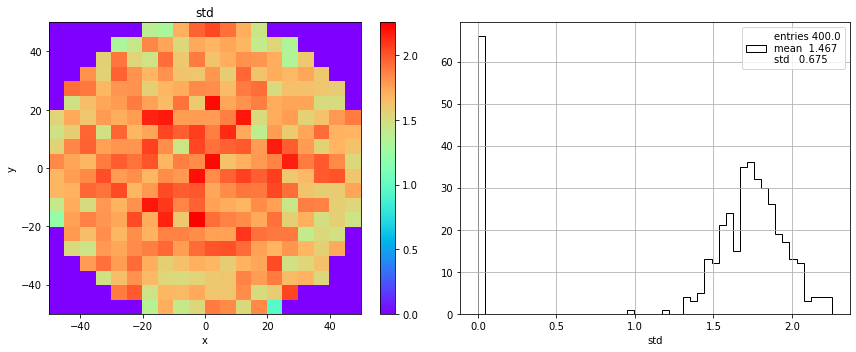

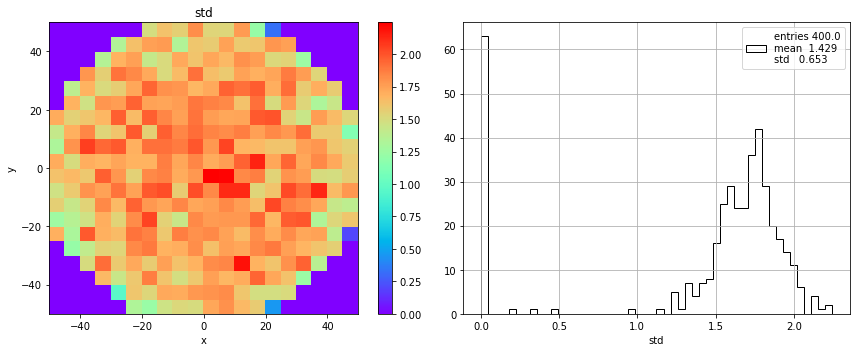

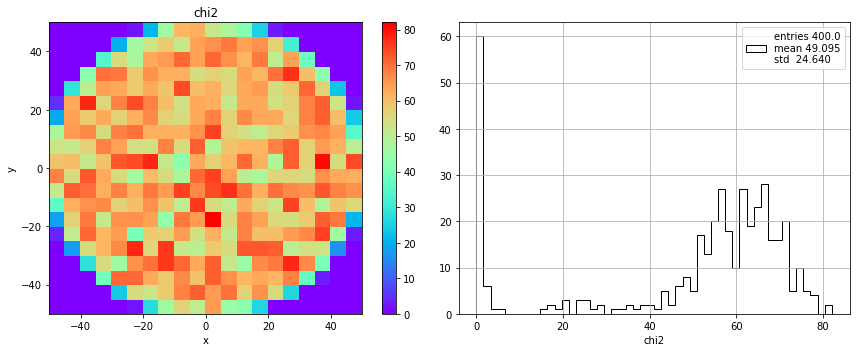

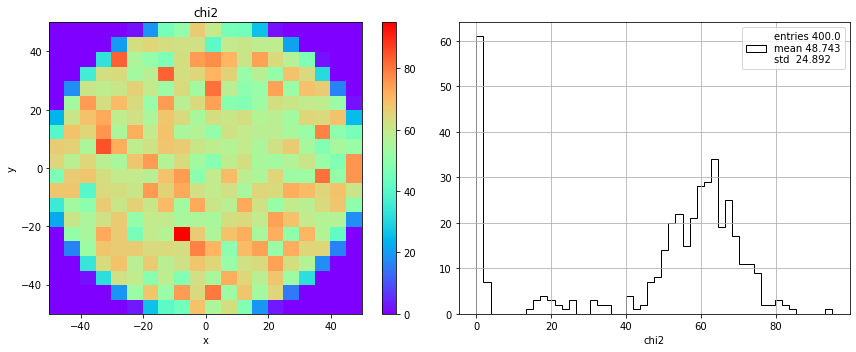

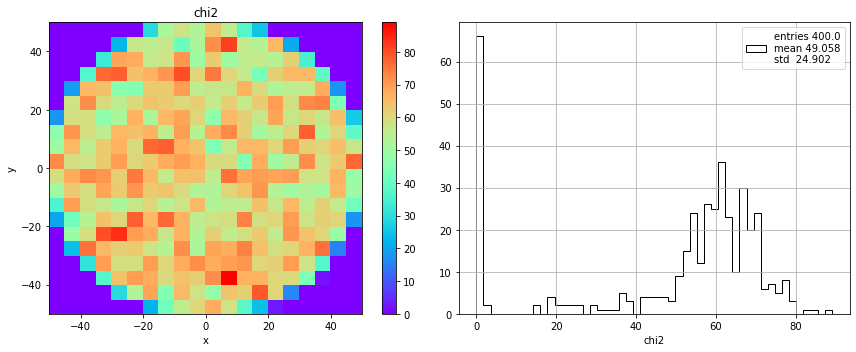

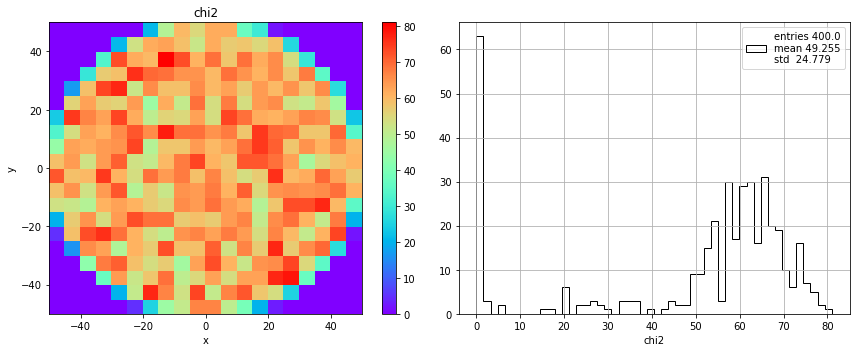

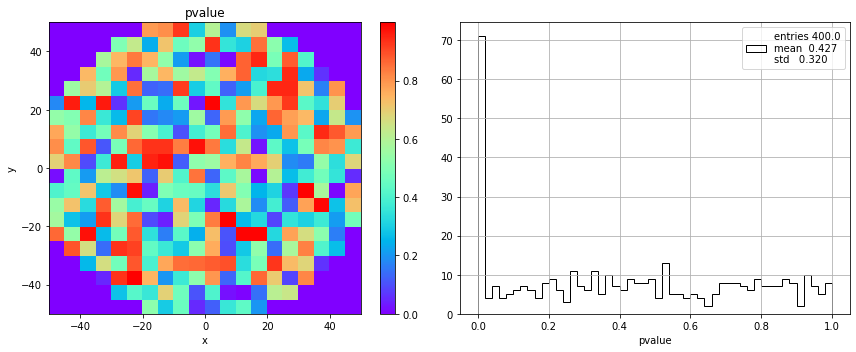

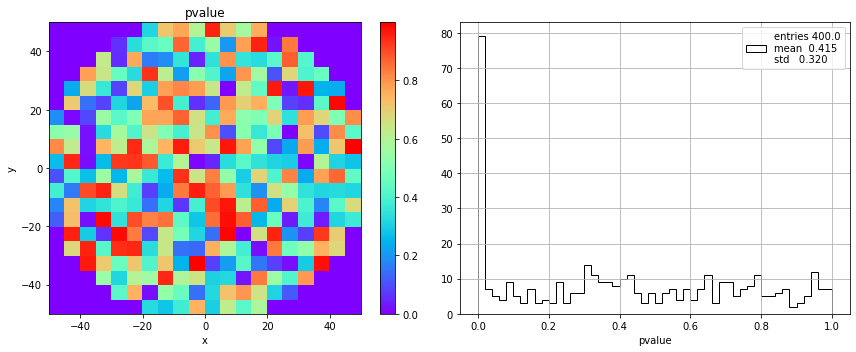

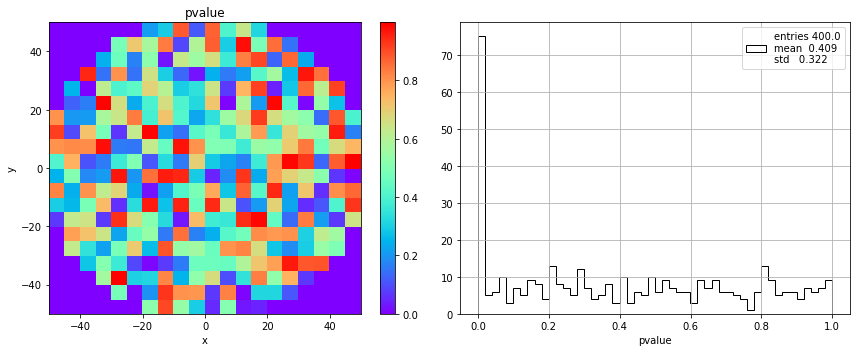

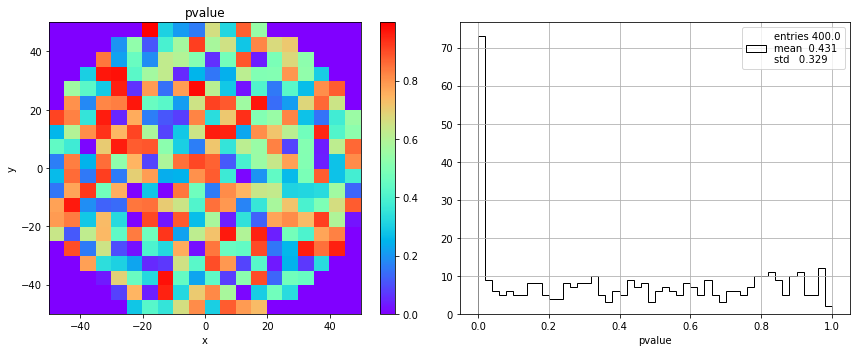

In [31]:
prof.plot_profile(krmap)

### corrections

In [32]:
corenergy = prof.profile_scale(coors, energy, krmap)
corkrmap  = prof.profile(coors, corenergy, bins)

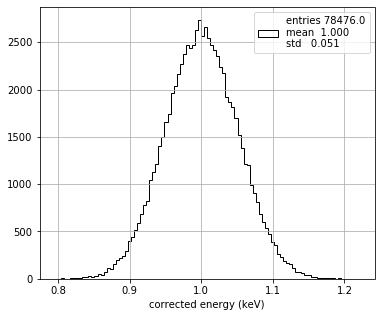

In [33]:
pltext.canvas(1, 1)
pltext.hist(corenergy, 100);
plt.xlabel('corrected energy (keV)');

### Validate correction

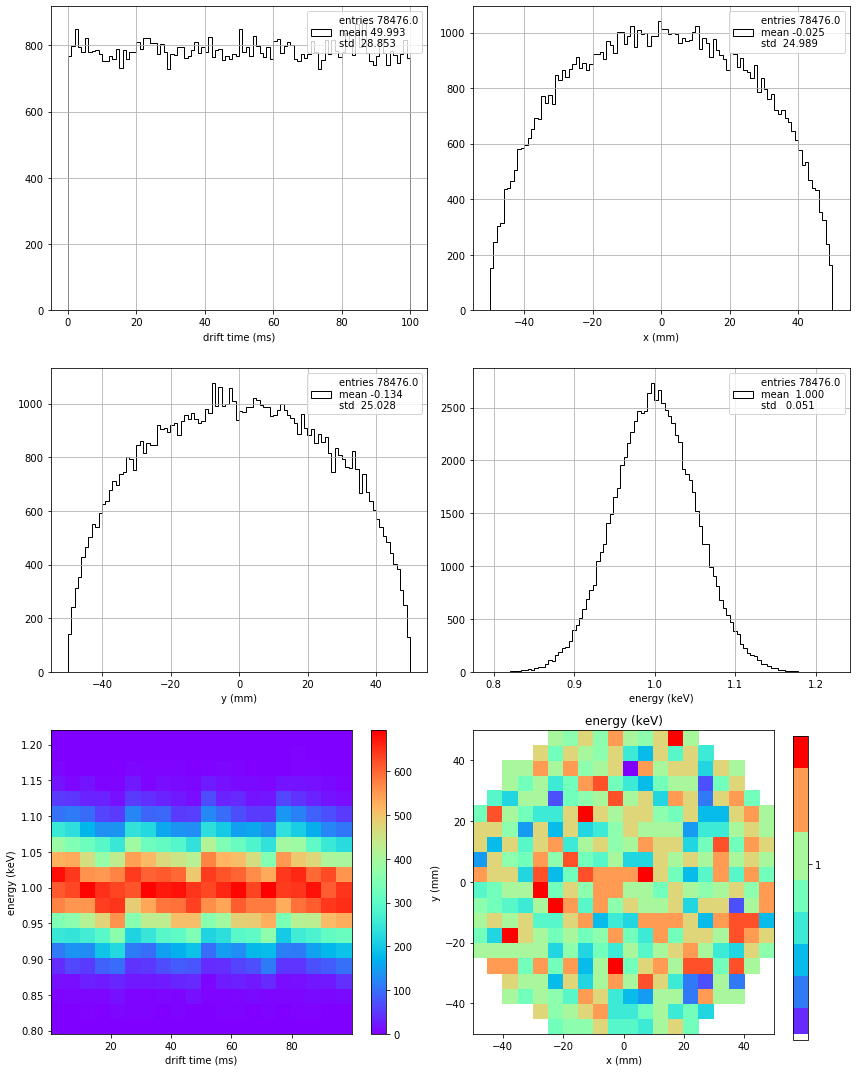

In [34]:
xdf = pd.DataFrame(df) 
xdf['energy'] = corenergy
plot_data(xdf)

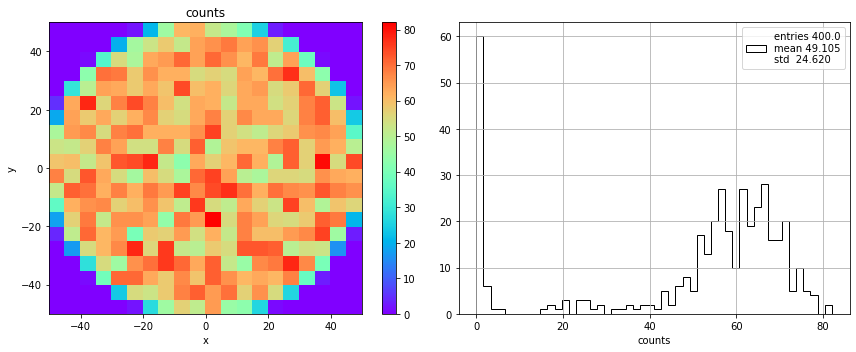

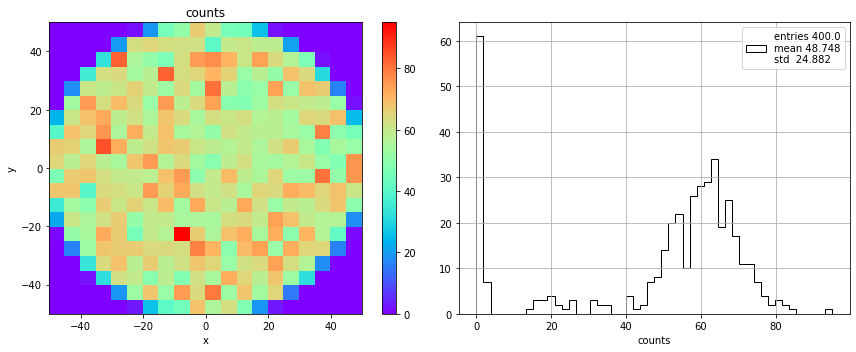

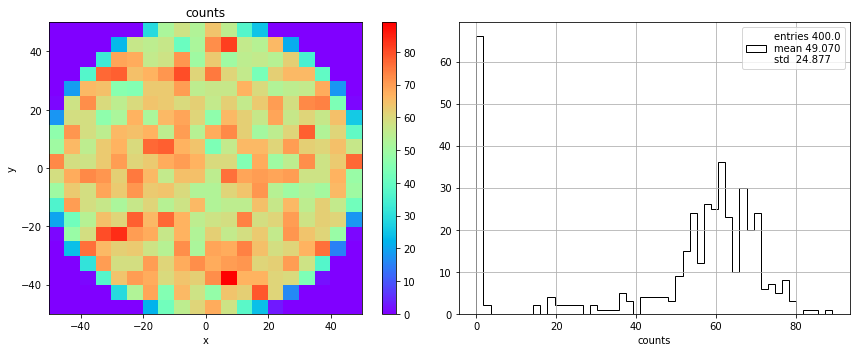

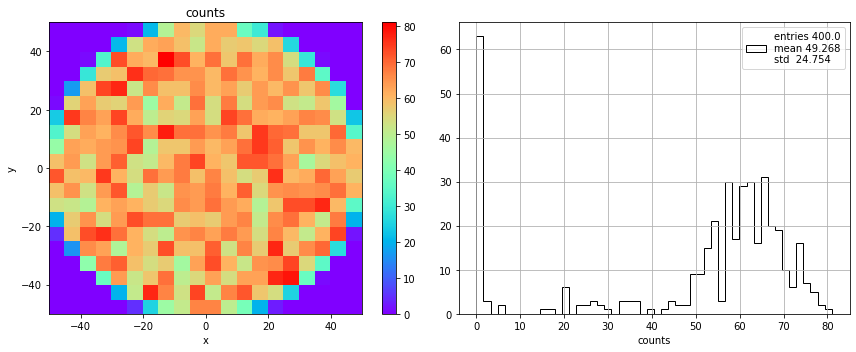

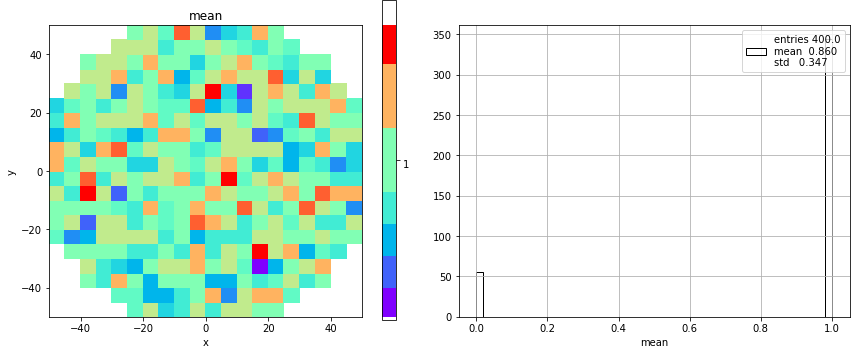

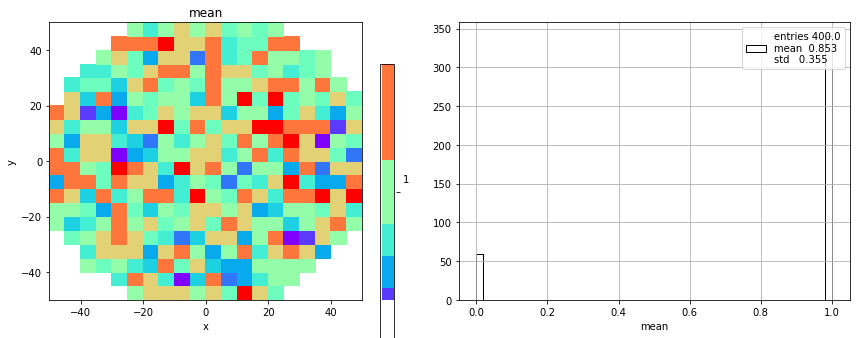

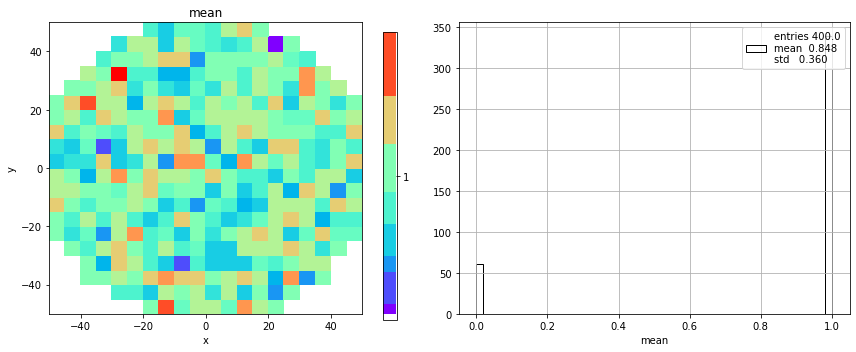

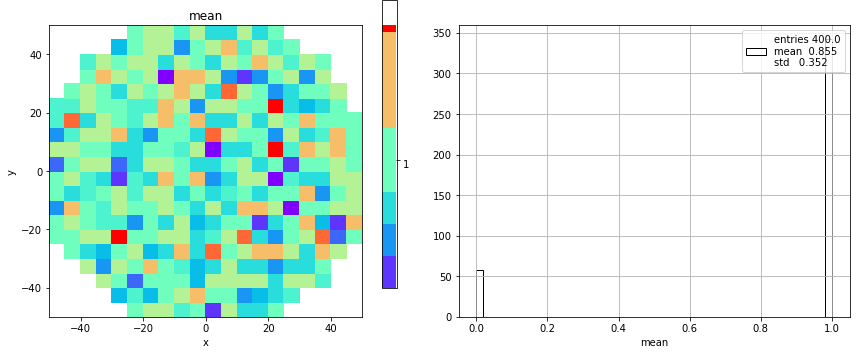

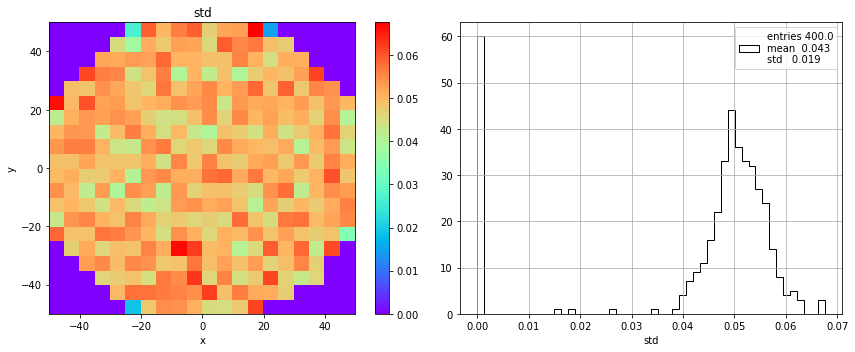

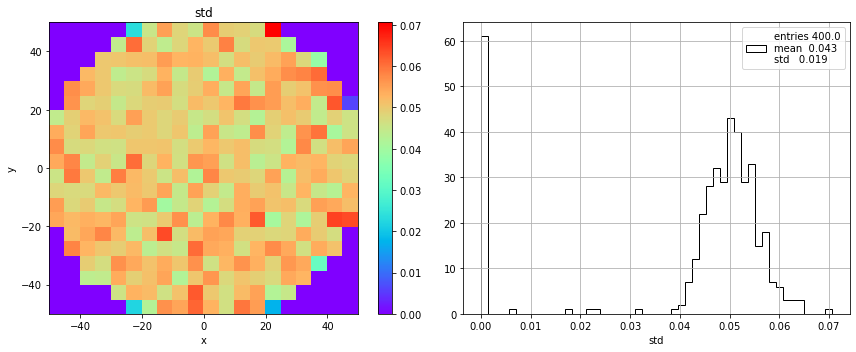

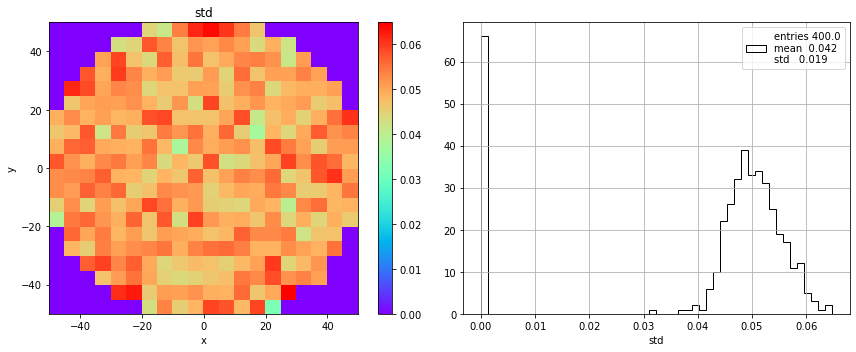

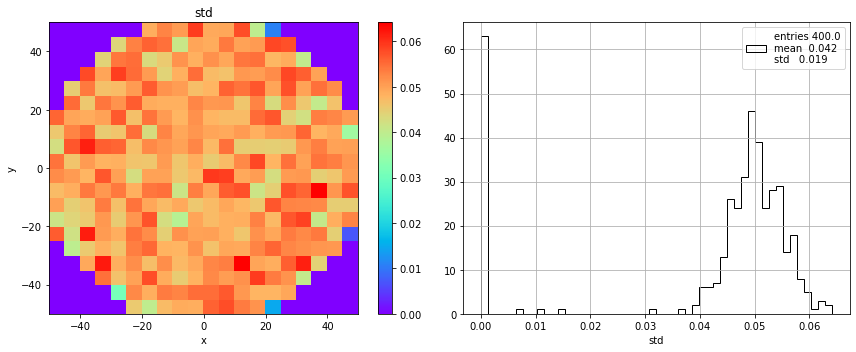

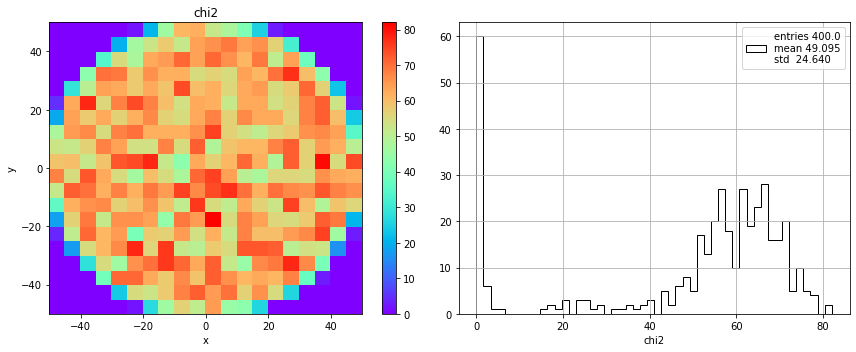

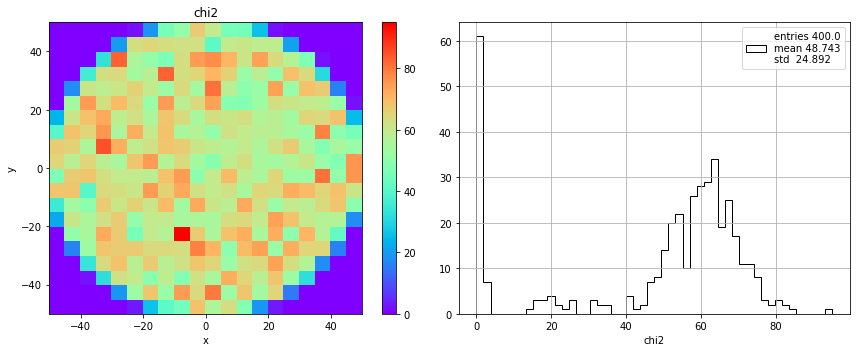

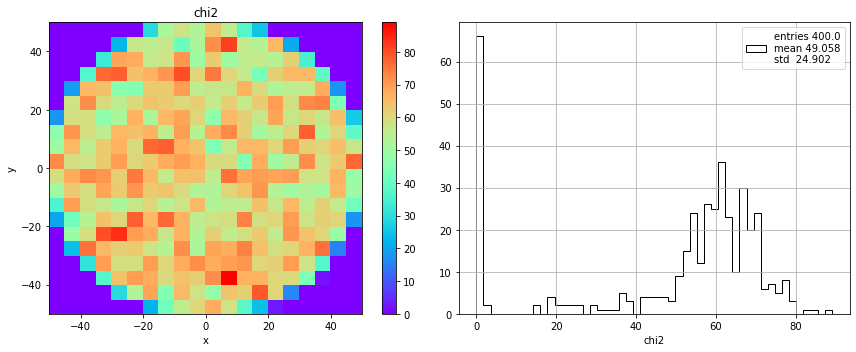

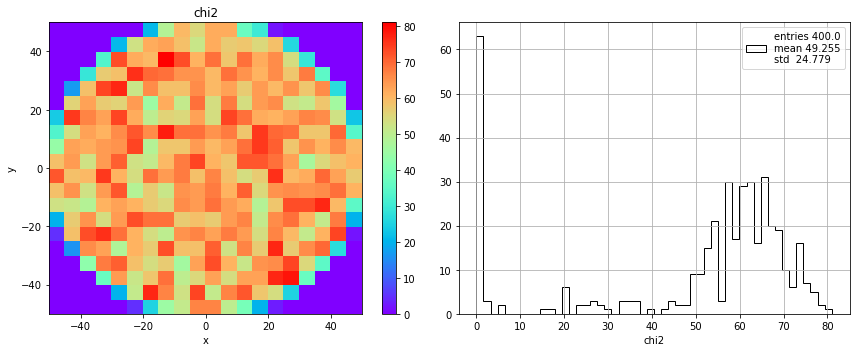

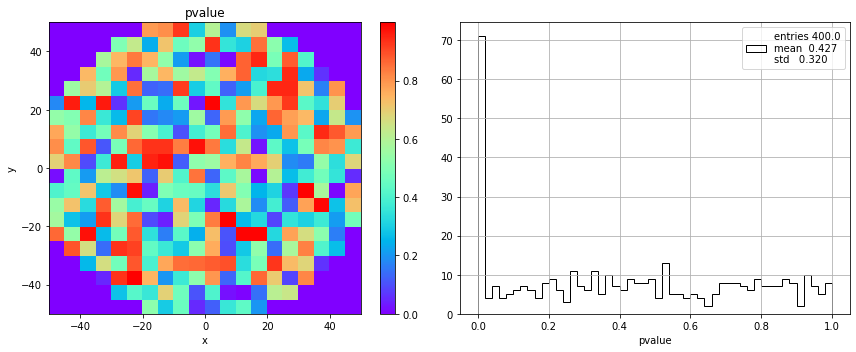

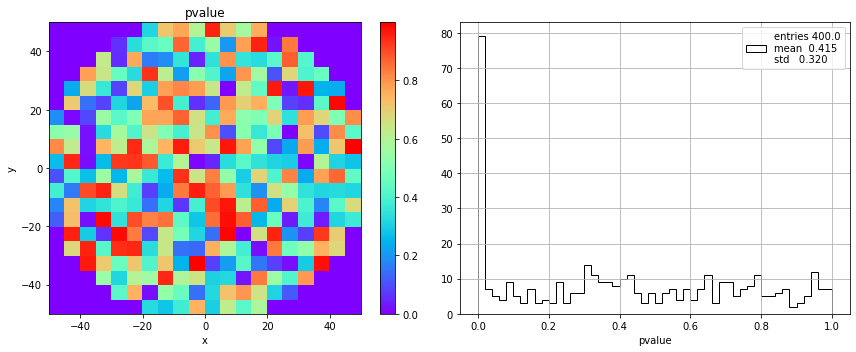

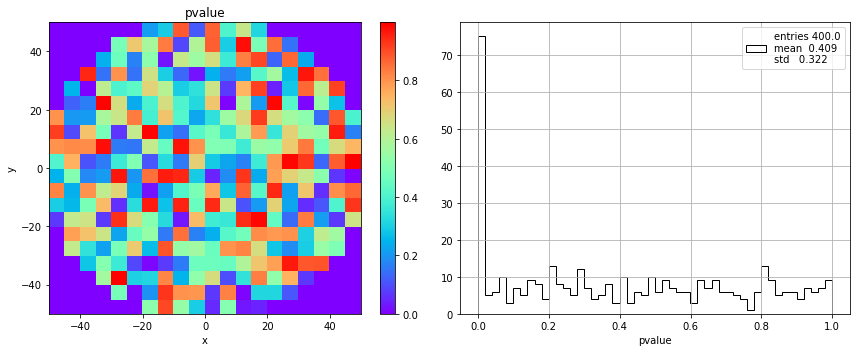

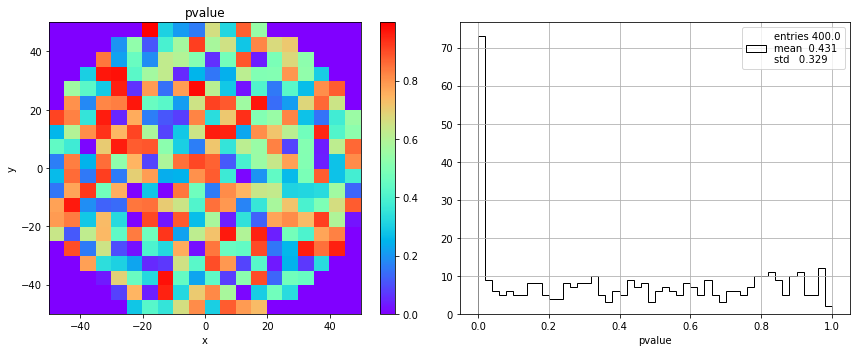

In [35]:
prof.plot_profile(corkrmap)